# Librerías y utilities

In [1]:
!pip install ripser
!pip install git+https://github.com/manu-mannattil/nolitsa.git
!pip install giotto-tda 
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=686998 sha256=7ef5d0bfa86262d7a76c169a917f3f113304b25e0cf454b86a122ec430756e15
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b049057431155934f74e20ca6001a085fcd2e615150
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=9d14d44f9daa562b350b26f774ac2f41cb3227bad3cdc357dd4a16615e743430
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built rip

In [2]:
!pip install -U giotto-tda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Librerías basicas de manipulación de objetos 
import pandas as pd
import seaborn as sns
import numpy as np

#Métodos estadisticos
from scipy.stats import anderson
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Conexión a Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Reduccion de dimensionalidad
from sklearn.decomposition import PCA

#Librerías Topologicas
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from nolitsa import dimension, delay
import ripser
import persim
from gtda.plotting import plot_point_cloud

#Graficas
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#ARIMA
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Mounted at /content/drive


# Lectura y estructura de los Datos

Lectura y estructuración de los datos en un DataFrame

In [4]:
#Se leen los datos del archivo .txt
data_reto2 = pd.read_csv('/content/drive/Shareddrives/Topología/sstoi.indices.txt')

In [5]:
data_reto2.columns=['x'] # renombrar la columna de los datos
df3 = data_reto2['x'].str.split(n=9, expand=True) # Se divide en las columnas de datos originales
df3.columns = ['column{}'.format(x+1) for x in df3.columns]
df3.rename(columns={'column1': 'Year','column2':'Month',
                    'column3': 'nino1+2','column4':'anom1+2',
                    'column5': 'nino3','column6':'anom3',
                    'column7': 'nino4','column8':'anom4',
                    'column9': 'nino3_4','column10':'anom3_4'},inplace=True) #Se cambia el nombre de las columnas
df3['date'] = pd.to_datetime(dict(year=df3.Year, month=df3.Month, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

In [6]:
#Se crea un nuevo dataframe sin las columnas Year y Month y con la fecha como index
sstoi_df= df3[['nino1+2',	'anom1+2',	'nino3',	'anom3',	'nino4',	'anom4',	'nino3_4',	'anom3_4',	'date']]
sstoi_df = sstoi_df.set_index(['date'])
sstoi_df = sstoi_df.apply(pd.to_numeric) # Convwertir los datos de object a numeric
sstoi_df

nino1+2  anom1+2  nino3  anom3  nino4  anom4  nino3_4  anom3_4
date                                                                      
1982-01-01    24.28    -0.24  25.84   0.17  28.01  -0.21    26.65     0.08
1982-02-01    25.38    -0.72  26.26  -0.11  27.99  -0.11    26.54    -0.20
1982-03-01    25.22    -1.38  26.92  -0.25  28.18  -0.05    27.09    -0.14
1982-04-01    24.57    -1.16  27.52  -0.05  28.61   0.10    27.83     0.02
1982-05-01    24.00    -0.62  27.70   0.49  29.19   0.40    28.37     0.49
...             ...      ...    ...    ...    ...    ...      ...      ...
2022-12-01    22.54    -0.30  24.48  -0.78  27.71  -0.73    25.81    -0.84
2023-01-01    24.27    -0.24  25.17  -0.50  27.62  -0.60    25.88    -0.69
2023-02-01    26.80     0.71  26.25  -0.13  27.58  -0.52    26.29    -0.44
2023-03-01    28.12     1.52  27.52   0.36  28.09  -0.14    27.23    -0.01
2023-04-01    28.18     2.45  28.02   0.44  28.81   0.30    27.99     0.19

[496 rows x 8 columns]

Información del dataframe

In [7]:
sstoi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 1982-01-01 to 2023-04-01
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nino1+2  496 non-null    float64
 1   anom1+2  496 non-null    float64
 2   nino3    496 non-null    float64
 3   anom3    496 non-null    float64
 4   nino4    496 non-null    float64
 5   anom4    496 non-null    float64
 6   nino3_4  496 non-null    float64
 7   anom3_4  496 non-null    float64
dtypes: float64(8)
memory usage: 34.9 KB


## Visualización de Datos

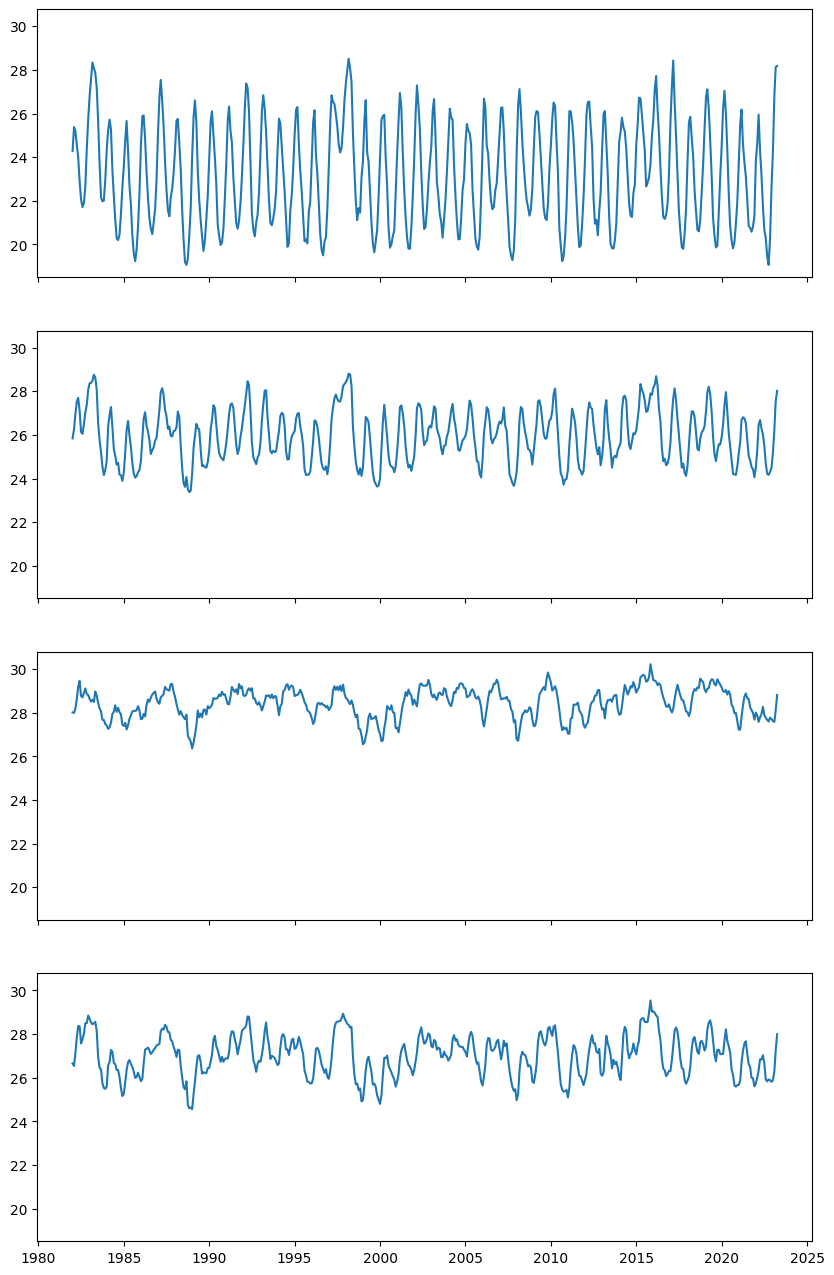

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True,figsize=(10,16))
date=sstoi_df.index
axs[0].plot(date, sstoi_df['nino1+2'])
axs[1].plot(date, sstoi_df['nino3'])
axs[2].plot(date, sstoi_df['nino4'])
axs[3].plot(date, sstoi_df['nino3_4'])

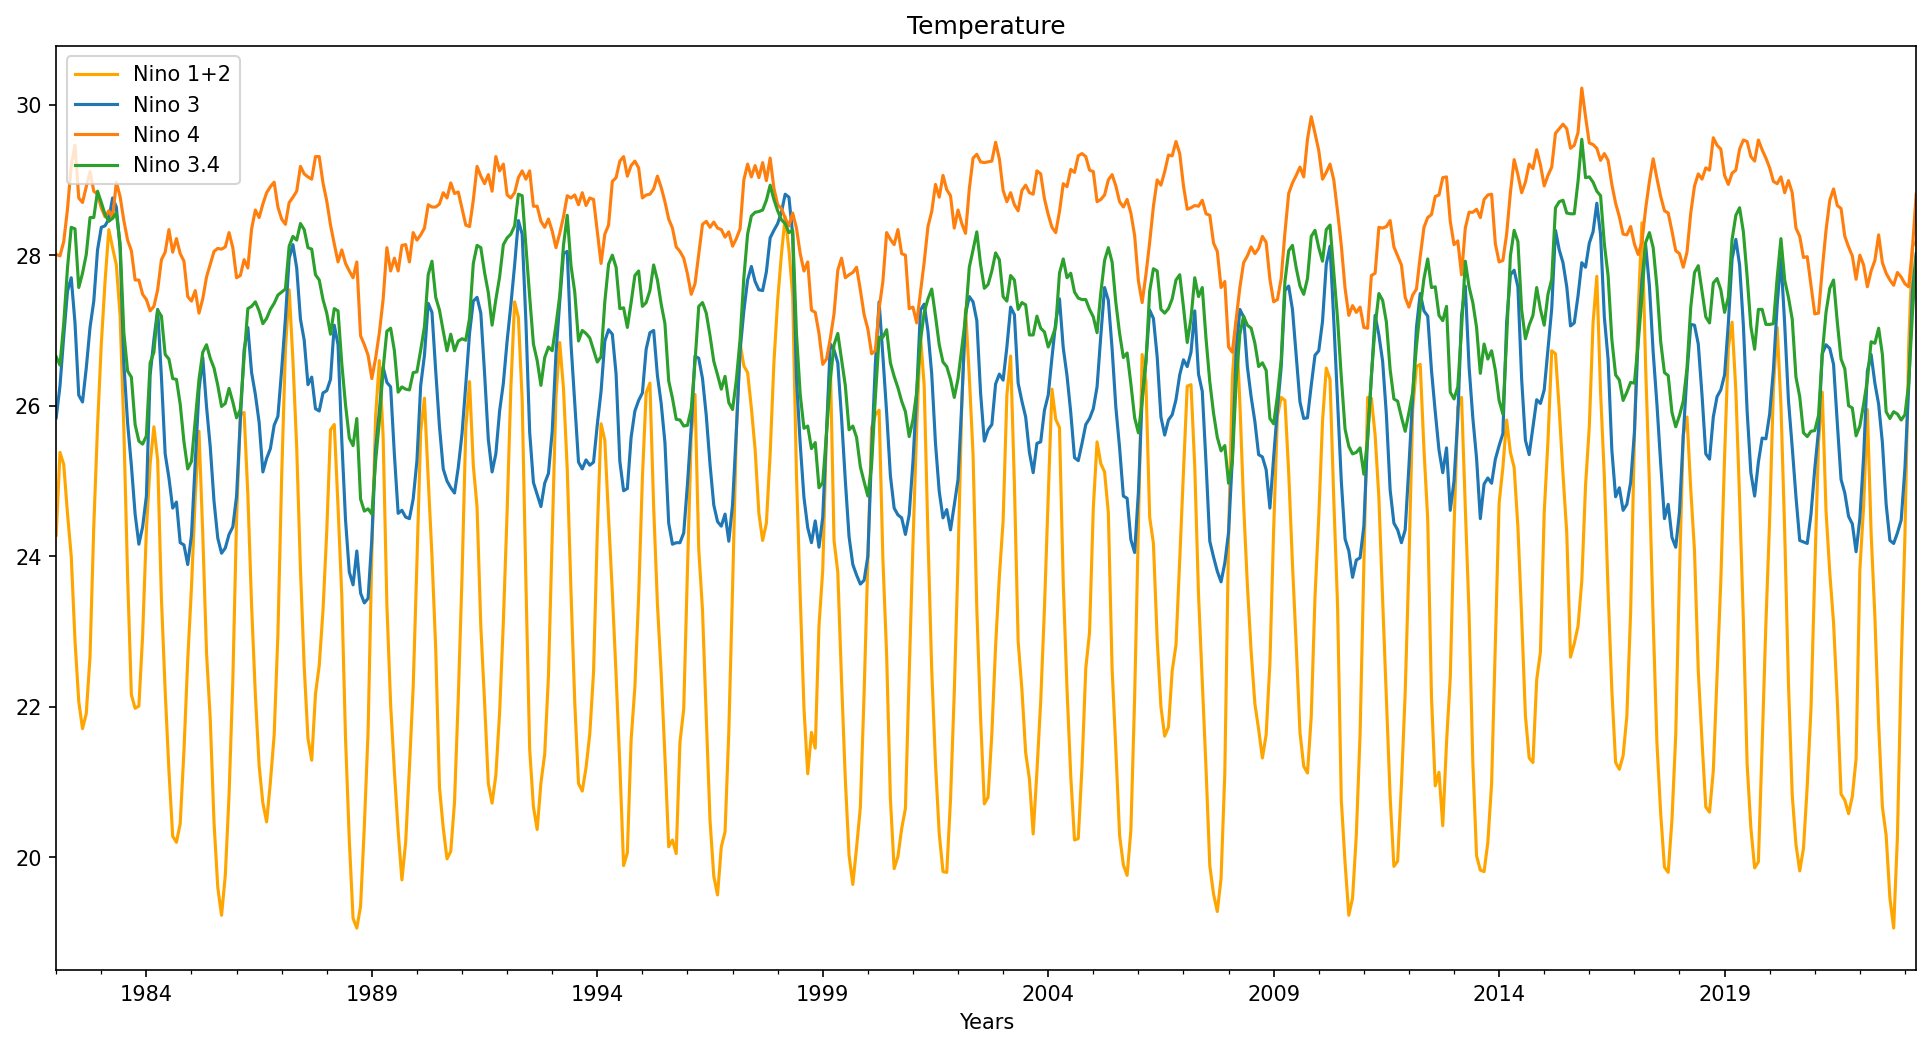

In [9]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
sstoi_df['nino1+2'].plot(label='Nino 1+2', color='orange')
sstoi_df['nino3'].plot(label='Nino 3')
sstoi_df['nino4'].plot(label='Nino 4')
sstoi_df['nino3_4'].plot(label='Nino 3.4')
  
# adding title to the plot
plt.title('Temperature')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend()

## Limpieza de los Datos

### Valores Nulos



In [10]:
sstoi_df.isna().sum()

nino1+2    0
anom1+2    0
nino3      0
anom3      0
nino4      0
anom4      0
nino3_4    0
anom3_4    0
dtype: int64

No existen valores nulos 

### Resumen estadístico

In [11]:
sstoi_df.describe()

nino1+2     anom1+2       nino3       anom3       nino4       anom4  \
count  496.000000  496.000000  496.000000  496.000000  496.000000  496.000000   
mean    23.238569   -0.059435   25.959617   -0.070262   28.448306   -0.103266   
std      2.325709    1.037774    1.229778    0.852488    0.678358    0.634563   
min     19.060000   -1.900000   23.380000   -2.160000   26.360000   -1.870000   
25%     21.217500   -0.742500   24.980000   -0.652500   27.997500   -0.570000   
50%     23.125000   -0.250000   25.930000   -0.170000   28.555000   -0.020000   
75%     25.222500    0.440000   26.872500    0.402500   28.970000    0.370000   
max     28.510000    4.030000   28.810000    3.070000   30.220000    1.550000   

          nino3_4     anom3_4  
count  496.000000  496.000000  
mean    27.010464   -0.082903  
std      0.942563    0.830024  
min     24.560000   -2.220000  
25%     26.337500   -0.670000  
50%     27.050000   -0.115000  
75%     27.682500    0.440000  
max     29.540000    2.720000

### Distribuciones

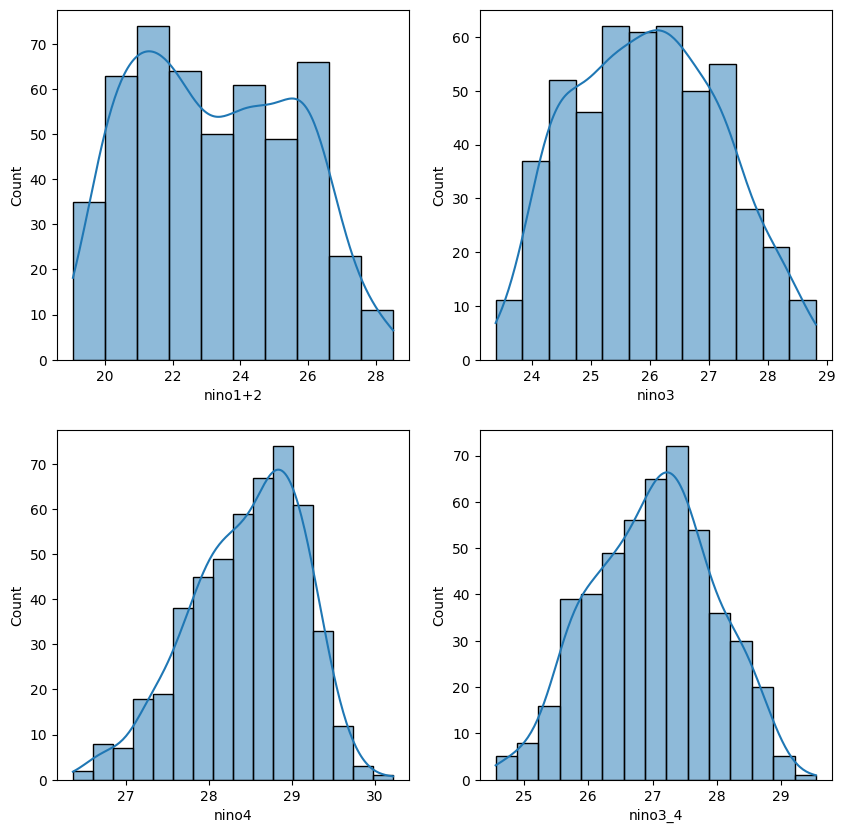

In [12]:
fig,axes=plt.subplots(2,2,figsize=(10, 10))

sns.histplot(sstoi_df['nino1+2'],ax=axes[0,0], kde=True)
sns.histplot(sstoi_df['nino3'],ax=axes[0,1], kde=True)
sns.histplot(sstoi_df['nino4'],ax=axes[1,0], kde=True)
sns.histplot(sstoi_df['nino3_4'],ax=axes[1,1], kde=True)

plt.show()

Pruebas de normalidad

In [13]:
anderson(sstoi_df['nino1+2'],dist='norm')

AndersonResult(statistic=5.528067121749245, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=23.238568548387097, scale=2.3257092254519334)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [14]:
anderson(sstoi_df['nino3'],dist='norm')

AndersonResult(statistic=1.8549064267608628, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=25.95961693548387, scale=1.2297775336450347)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [15]:
anderson(sstoi_df['nino4'],dist='norm')

AndersonResult(statistic=2.956182659844842, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=28.448306451612904, scale=0.6783580554192837)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [16]:
anderson(sstoi_df['nino3_4'],dist='norm')

AndersonResult(statistic=0.7318227174966978, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=27.010463709677417, scale=0.9425628005728777)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

### Análisis de Correlación

#### Autocorrelación

In [17]:
import statsmodels.api as sm

**Temperatura**

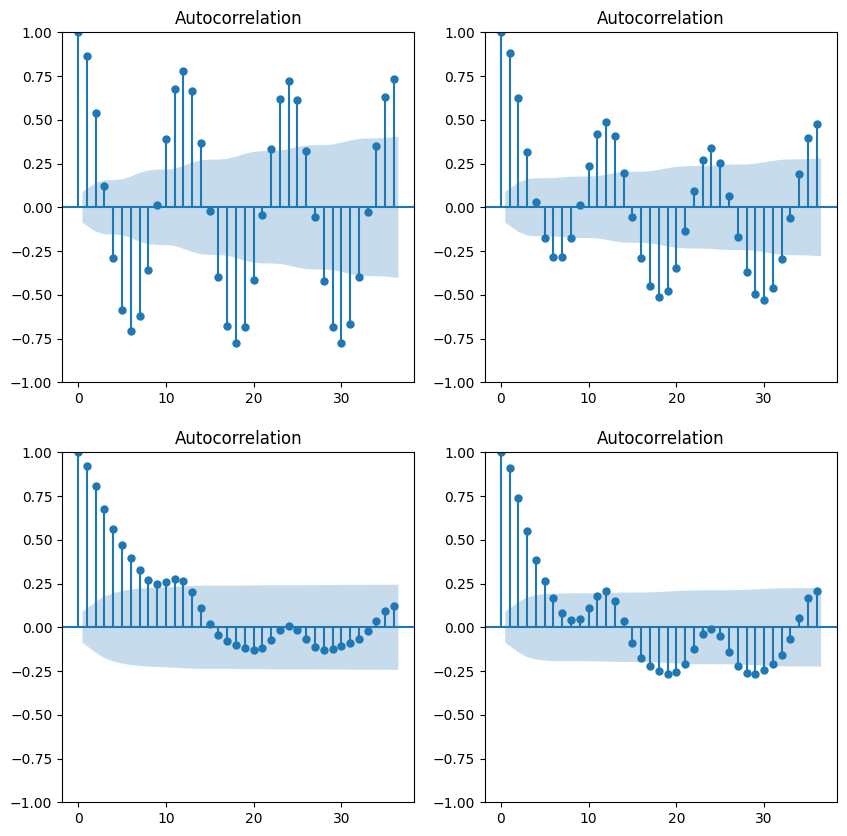

0.869278017261082
0.8862418735307973
0.9225530160231058
0.9116667727423039


In [18]:
fig,axes=plt.subplots(2,2,figsize=(10, 10))
sm.graphics.tsa.plot_acf(sstoi_df['nino1+2'], lags=36,ax=axes[0,0])
sm.graphics.tsa.plot_acf(sstoi_df['nino3'], lags=36,ax=axes[0,1])
sm.graphics.tsa.plot_acf(sstoi_df['nino4'], lags=36,ax=axes[1,0])
sm.graphics.tsa.plot_acf(sstoi_df['nino3_4'], lags=36,ax=axes[1,1])

plt.show()

print(sstoi_df['nino1+2'].autocorr(lag=1))
print(sstoi_df['nino3'].autocorr(lag=1))
print(sstoi_df['nino4'].autocorr(lag=1))
print(sstoi_df['nino3_4'].autocorr(lag=1))


#### Correlacion entre variables

In [19]:
#Matriz de correlación entre las mediciones de temperatura
corr_matrix1 = round(sstoi_df.corr(), 2)
print(corr_matrix1)

         nino1+2  anom1+2  nino3  anom3  nino4  anom4  nino3_4  anom3_4
nino1+2     1.00     0.44   0.78   0.35  -0.04   0.19     0.39     0.27
anom1+2     0.44     1.00   0.54   0.80   0.39   0.42     0.54     0.63
nino3       0.78     0.54   1.00   0.69   0.43   0.51     0.85     0.64
anom3       0.35     0.80   0.69   1.00   0.67   0.72     0.82     0.94
nino4      -0.04     0.39   0.43   0.67   1.00   0.93     0.80     0.82
anom4       0.19     0.42   0.51   0.72   0.93   1.00     0.78     0.88
nino3_4     0.39     0.54   0.85   0.82   0.80   0.78     1.00     0.87
anom3_4     0.27     0.63   0.64   0.94   0.82   0.88     0.87     1.00


### Características de las series de Tiempo

#### Estacionalidad y Tendencia

**Niño1+2**

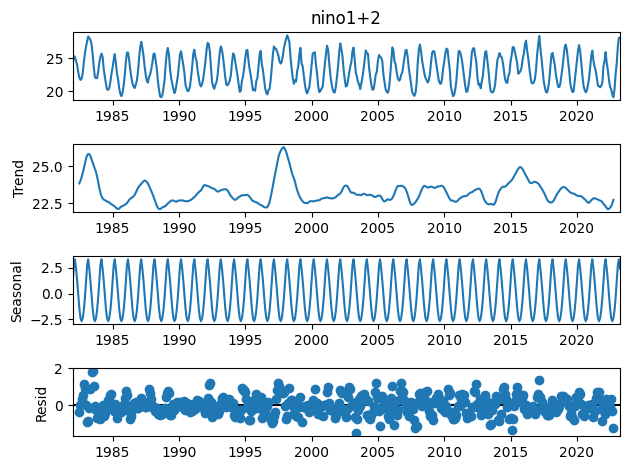

In [20]:
seasonal_decompose(sstoi_df['nino1+2'], period=12).plot()
plt.show()

**Niño3**

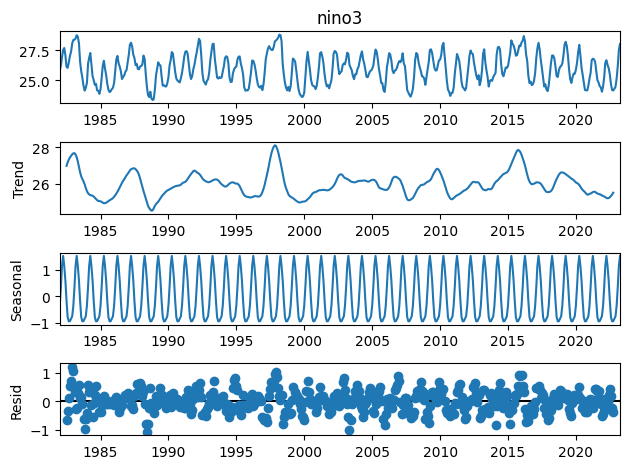

In [21]:
seasonal_decompose(sstoi_df['nino3'], period=12).plot()
plt.show()

**Niño 4**

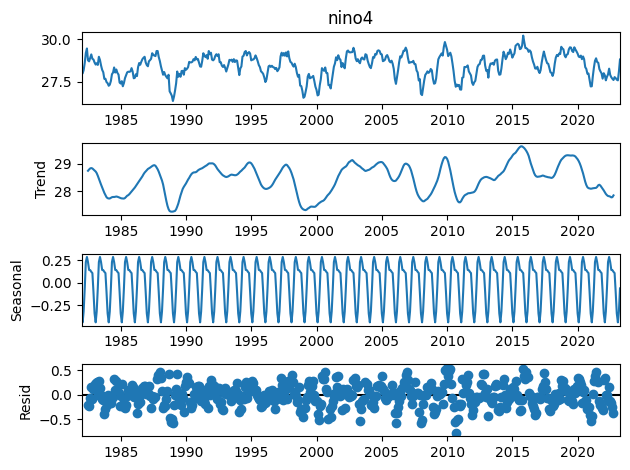

In [22]:
seasonal_decompose(sstoi_df['nino4'], period=12).plot()
plt.show()

**Niño3.4**

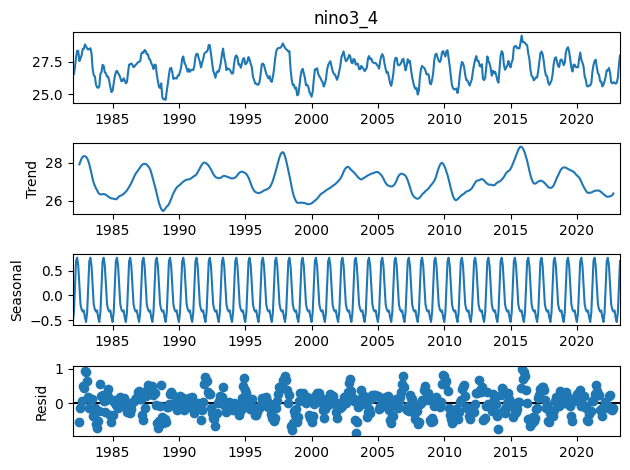

In [23]:
seasonal_decompose(sstoi_df['nino3_4'], period=12).plot()
plt.show()

#### Estacionaridad

https://machinelearningmastery.com/time-series-data-stationary-python/

In [24]:
from statsmodels.tsa.stattools import adfuller

**Niño1**

In [25]:
result=adfuller(sstoi_df['nino1+2'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.841658
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


**Niño 3**

In [26]:
result=adfuller(sstoi_df['nino3'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.033099
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


**Niño 4**

In [27]:
result=adfuller(sstoi_df['nino4'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.223398
p-value: 0.000601
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


**Ninño 3.4**

In [28]:
result=adfuller(sstoi_df['nino3_4'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.193958
p-value: 0.000009
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


#### Periodicidad

https://periodicity.readthedocs.io

# Análisis Topológico Inicial

## Takens Embedding

In [29]:
#Inicialización de parametros
max_periodic_dimension=22
max_periodic_time_delay=22
stride=12

In [30]:
#Inicialización de la función search de SngleTakensEmbedding
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)

### **Optimización de Parámetros**

####Nino 1+2

**Takens Embedding Optimal Parameters con Stride 12**

In [31]:
tau1,d1= takens_embedding_optimal_parameters(sstoi_df['nino1+2'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay Nino1+2: ', tau1,'\nOptimal dimension Nino1+2: ', d1, '\n')

Optimal time delay Nino1+2:  3 
Optimal dimension Nino1+2:  6 



**Función Search con Stride 1**

In [32]:
nino1_2_embedded = embedder_periodic.fit_transform(sstoi_df['nino1+2'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  3
La dimensión encontrada es  8


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  5


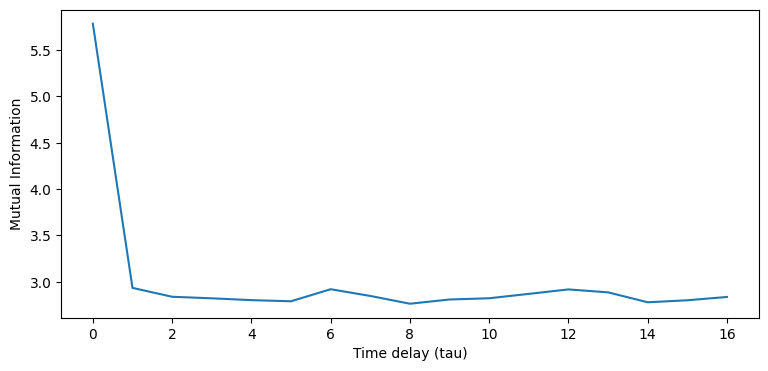

In [33]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['nino1+2'], maxtau=17))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['nino1+2'], maxtau=30))

La dimensión óptima con tau=5 es:  2


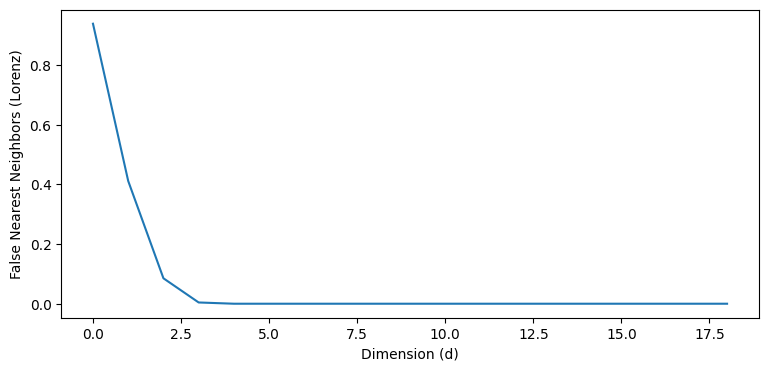

In [34]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['nino1+2'], 
                           dim=test_dim, 
                           tau=5, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=5 es: ", [f<=0.1 for f in f1].index(True))

####Nino 1+2 Anom

**Takens Embedding Optimal Parameters con Stride 12**

In [35]:
tau5,d5= takens_embedding_optimal_parameters(sstoi_df['anom1+2'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay anom1+2: ', tau5,'\nOptimal dimension anom1+2:', d5, '\n')

Optimal time delay anom1+2:  16 
Optimal dimension anom1+2: 3 



**Función Search con Stride 1**

In [36]:
anom1_2_embedded = embedder_periodic.fit_transform(sstoi_df['anom1+2'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  16
La dimensión encontrada es  5


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  5


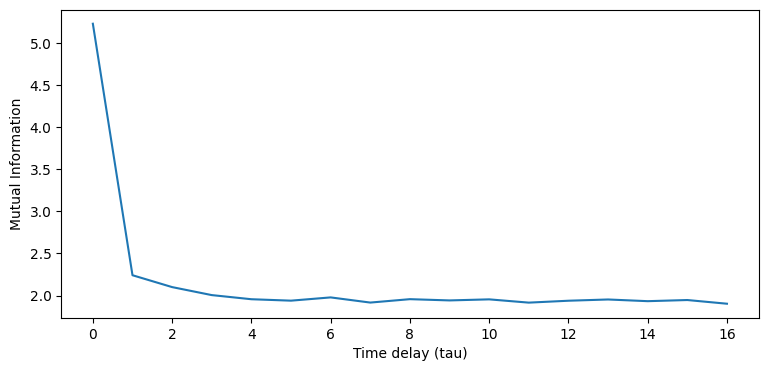

In [37]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['anom1+2'], maxtau=17))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['anom1+2'], maxtau=30))

La dimensión óptima con tau=5 es:  2


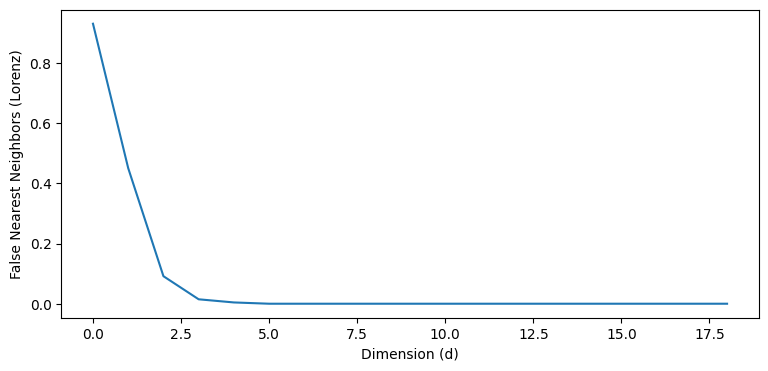

In [38]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['anom1+2'], 
                           dim=test_dim, 
                           tau=5, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=5 es: ", [f<=0.1 for f in f1].index(True))

####Nino3

**Takens Embedding Optimal Parameters con Stride 12**

In [39]:
tau2,d2= takens_embedding_optimal_parameters(sstoi_df['nino3'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay Nino3: ', tau2,'\nOptimal dimension Nino3: ', d2, '\n')

Optimal time delay Nino3:  15 
Optimal dimension Nino3:  3 



**Función Search con Stride 1**

In [40]:
nino3_embedded = embedder_periodic.fit_transform(sstoi_df['nino3'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  15
La dimensión encontrada es  5


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  2


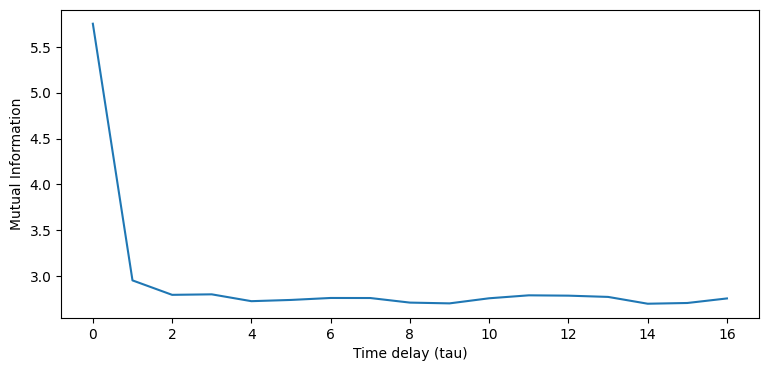

In [41]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['nino3'], maxtau=17))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['nino3'], maxtau=30))

La dimensión óptima con tau=2 es:  2


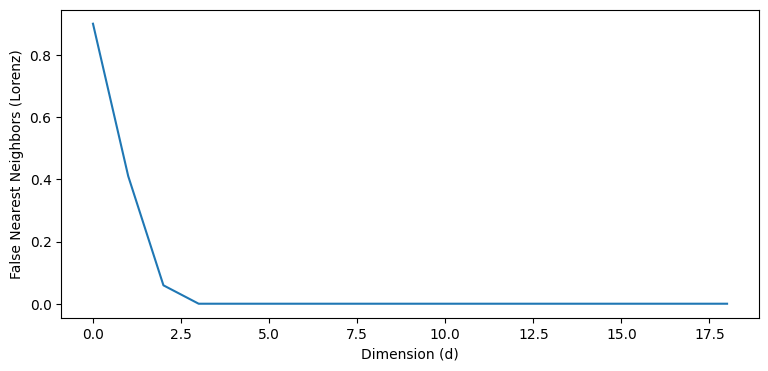

In [42]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['nino3'], 
                           dim=test_dim, 
                           tau=2, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=2 es: ", [f<=0.1 for f in f1].index(True))

#### Nino3 Anom

**Takens Embedding Optimal Parameters con Stride 12**

In [43]:
tau6,d6= takens_embedding_optimal_parameters(sstoi_df['anom3'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay Anom3: ', tau6,'\nOptimal dimension Anom3: ', d6, '\n')

Optimal time delay Anom3:  19 
Optimal dimension Anom3:  2 



**Función Search con Stride 1**

In [44]:
anom3_embedded = embedder_periodic.fit_transform(sstoi_df['anom3'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  19
La dimensión encontrada es  6


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  5


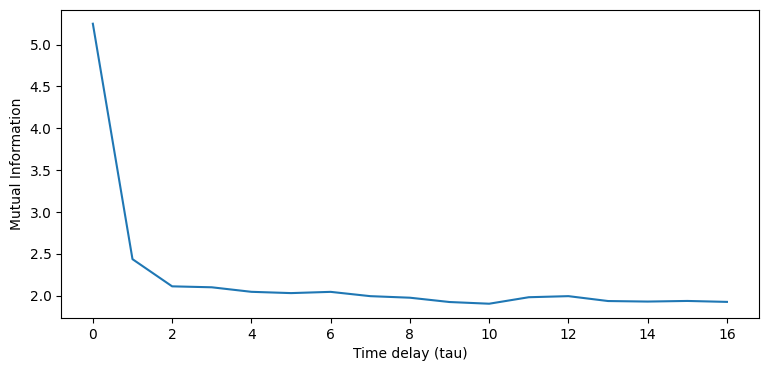

In [45]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['anom3'], maxtau=17))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['anom3'], maxtau=30))

La dimensión óptima con tau=5 es:  2


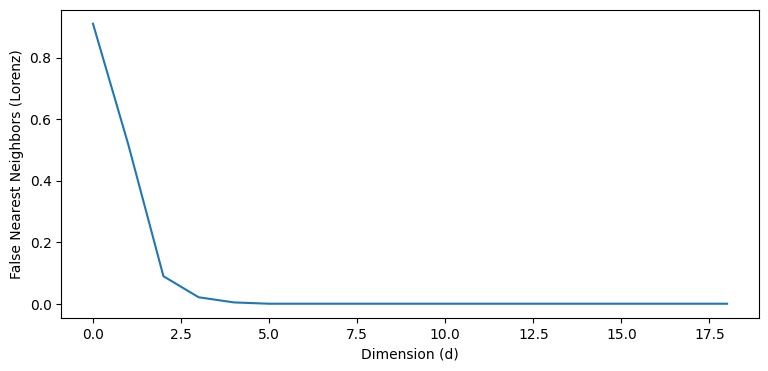

In [46]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['anom3'], 
                           dim=test_dim, 
                           tau=5, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=5 es: ", [f<=0.1 for f in f1].index(True))

####Niño4

**Takens Embedding Optimal Parameters con Stride 12**

In [47]:
tau3,d3= takens_embedding_optimal_parameters(sstoi_df['nino4'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay Nino4: ', tau3,'\nOptimal dimension Nino4: ', d3, '\n')

Optimal time delay Nino4:  6 
Optimal dimension Nino4:  2 



**Función Search con Stride 1**

In [48]:
nino4_embedded = embedder_periodic.fit_transform(sstoi_df['nino4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  6
La dimensión encontrada es  7


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  6


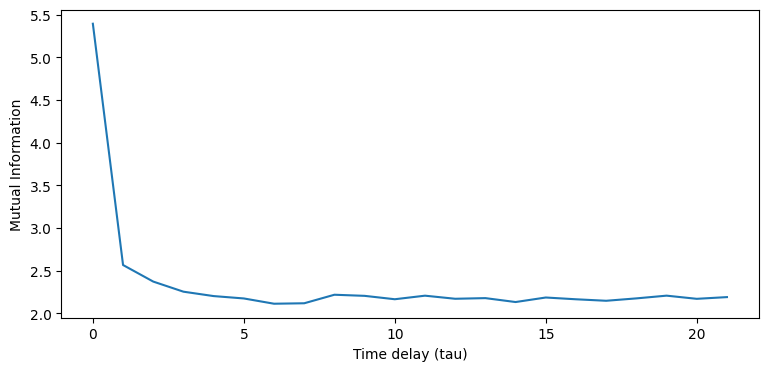

In [49]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['nino4'], maxtau=22))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['nino4'], maxtau=30))

La dimensión óptima con tau=6 es:  2


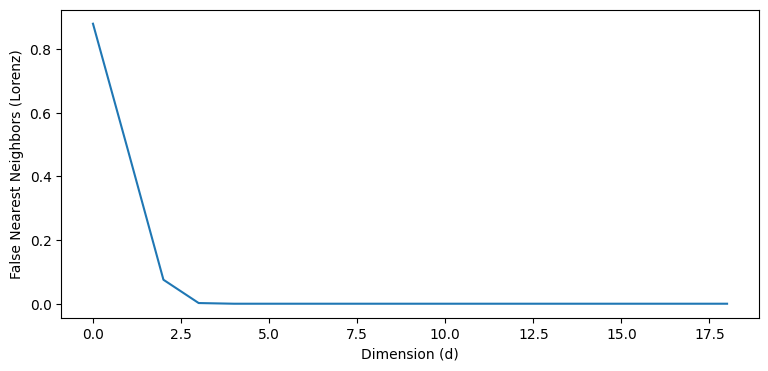

In [50]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['nino4'], 
                           dim=test_dim, 
                           tau=6, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=6 es: ", [f<=0.1 for f in f1].index(True))

####Niño4 Anom

**Takens Embedding Optimal Parameters con Stride 12**

In [51]:
tau7,d7= takens_embedding_optimal_parameters(sstoi_df['anom4'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay anom4: ', tau7,'\nOptimal dimension anom4: ', d7, '\n')

Optimal time delay anom4:  12 
Optimal dimension anom4:  3 



**Función Search con Stride 1**

In [52]:
anom4_embedded = embedder_periodic.fit_transform(sstoi_df['anom4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

El delay encontrado es  12
La dimensión encontrada es  5


**Busqueda de Óptimos locales con gráficas**

El delay óptimo es:  4


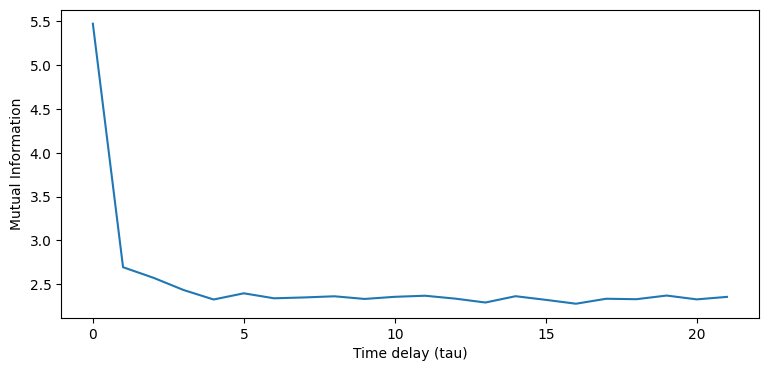

In [53]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['anom4'], maxtau=22))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['anom4'], maxtau=30))

La dimensión óptima con tau=4 es:  2


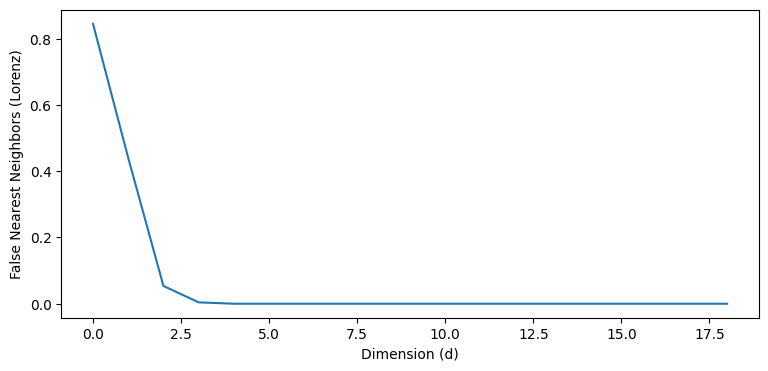

In [54]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['anom4'], 
                           dim=test_dim, 
                           tau=4, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=4 es: ", [f<=0.1 for f in f1].index(True))

####Nino3_4

**Takens Embedding Optimal Parameters con Stride 12**

In [55]:
tau4,d4= takens_embedding_optimal_parameters(sstoi_df['nino3_4'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay Nino3_4: ', tau4,'\nOptimal dimension NIno3_4: ', d4, '\n')

Optimal time delay Nino3_4:  17 
Optimal dimension NIno3_4:  3 



**Función Search con Stride 1**

In [56]:
nino3_4_embedded = embedder_periodic.fit_transform(sstoi_df['nino3_4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("El delay encontrado es ", embedder_periodic.dimension_)

El delay encontrado es  17
El delay encontrado es  8


**Busqueda de Óptimos locales con gráficas**



El delay óptimo es:  4


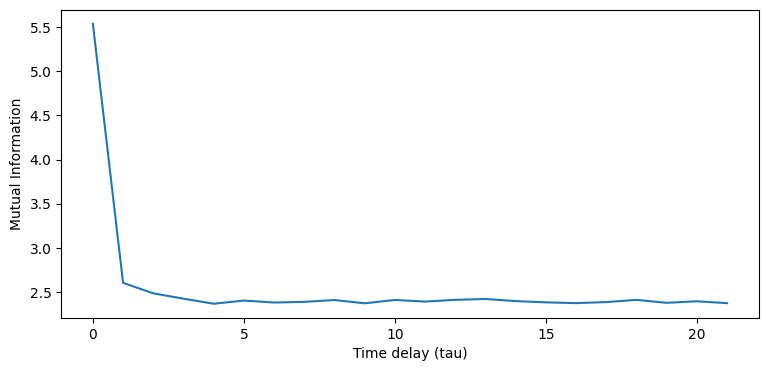

In [57]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['nino3_4'], maxtau=22))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['nino3_4'], maxtau=30))

La dimensión óptima con tau=4 es:  2


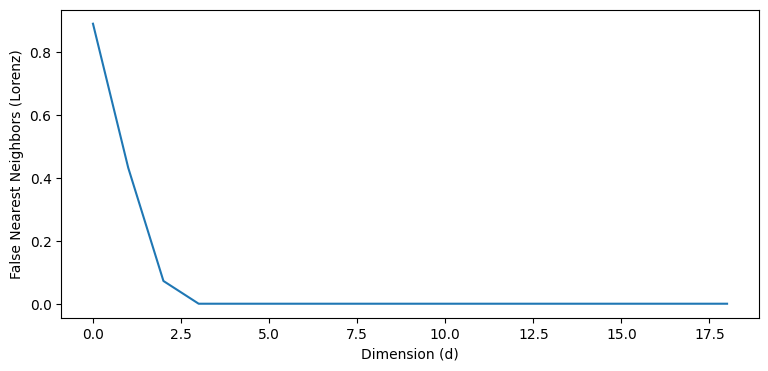

In [58]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['nino3_4'], 
                           dim=test_dim, 
                           tau=4, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=4 es: ", [f<=0.1 for f in f1].index(True))

#### Anom3_4

**Takens Embedding Optimal Parameters con Stride 12**

In [59]:
tau8,d8= takens_embedding_optimal_parameters(sstoi_df['anom3_4'], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay anom3_4: ', tau8,'\nOptimal dimension anom3_4: ', d8, '\n')

Optimal time delay anom3_4:  14 
Optimal dimension anom3_4:  2 



**Función Search con Stride 1**

In [60]:
anom3_4_embedded = embedder_periodic.fit_transform(sstoi_df['anom3_4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("El delay encontrado es ", embedder_periodic.dimension_)

El delay encontrado es  14
El delay encontrado es  6


**Busqueda de Óptimos locales con gráficas**



El delay óptimo es:  2


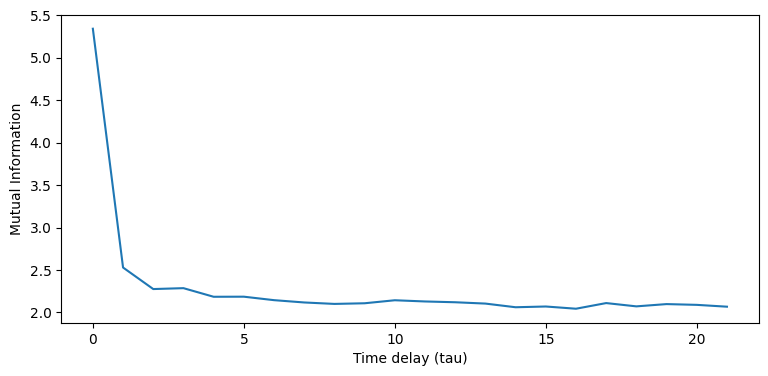

In [61]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(sstoi_df['anom3_4'], maxtau=22))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

print("El delay óptimo es: ", find_optimal_delay(sstoi_df['anom3_4'], maxtau=30))

La dimensión óptima con tau=2 es:  2


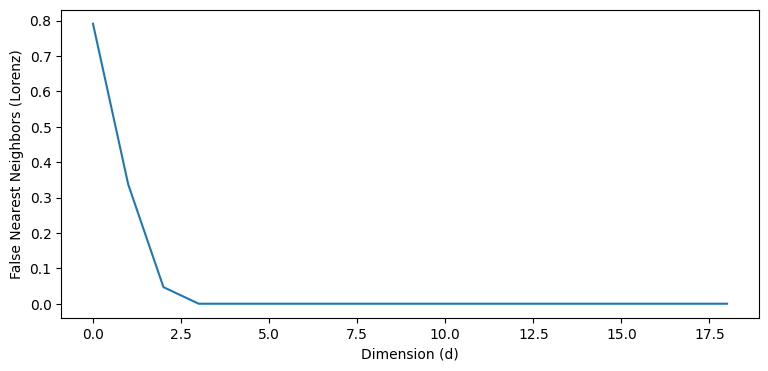

In [62]:
test_dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(x=sstoi_df['anom3_4'], 
                           dim=test_dim, 
                           tau=2, 
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=2 es: ", [f<=0.1 for f in f1].index(True))

### **Embedding**

In [63]:
#Funcion auxiliar para hacer el embedding
def embed2(points,dimemb=2,time_delay=100):
    auxembed=[]
    for i in range(0,len(points)+(-dimemb+1)*time_delay):
        aux=[points[i+j*time_delay] for j in range(dimemb)]
        auxembed.append(aux)
    auxembed=np.array(auxembed)
    return auxembed


#PCA para visualizar los que tienen dim>2
pca_viz = PCA(n_components=3)

#### Nino 1+2

In [64]:
#Embedding con Función Auxiliar
#embed_nino1_2_2 =embed2(sstoi_df["nino1+2"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino1_2_3 =embed2(sstoi_df["nino1+2"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_121 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=3,dimension=6,stride=12,)
nino12_embed1 = embedder_121.fit_transform(sstoi_df['nino1+2']) #TakensEmbeddingOptimalParameters
embedder_122 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=3,dimension=8,stride=1,)
nino12_embed2 = embedder_122.fit_transform(sstoi_df['nino1+2']) #Fncion Search
embedder_123 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=5,dimension=2,stride=1,)
nino12_embed3 = embedder_123.fit_transform(sstoi_df['nino1+2']) #Optimos Locales

#PCA para visualización
#embed_nino121a_viz = pca_viz.fit_transform(embed_nino1_2_2)
embed_nino121_viz = pca_viz.fit_transform(nino12_embed1)
embed_nino122_viz = pca_viz.fit_transform(nino12_embed2)

##### Visualizaciones

######**Delay 3, Dimensión 6, Stride 12**

In [65]:
plot_point_cloud(embed_nino121_viz)

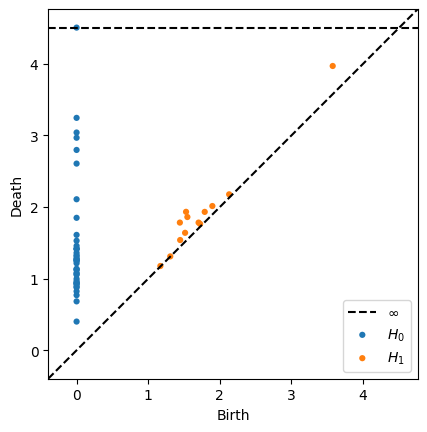

In [66]:
ripsprueba=ripser.ripser(nino12_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 3, Dimensión 8, Stride 1**

In [67]:
plot_point_cloud(embed_nino122_viz)

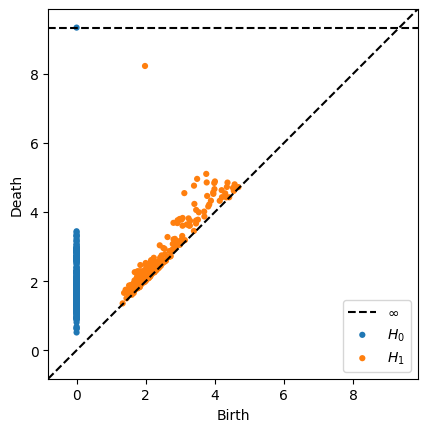

In [68]:
ripsprueba=ripser.ripser(nino12_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 5, Dimensión 2, Stride 1**

In [69]:
plot_point_cloud(nino12_embed3)

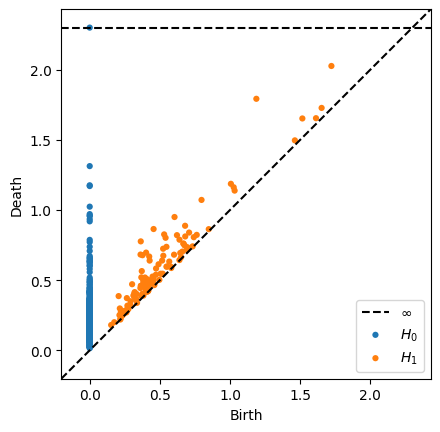

In [70]:
ripsprueba=ripser.ripser(nino12_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Anom 1+2

In [71]:
#Embedding con Función Auxiliar
#embed_nino1_2_2 =embed2(sstoi_df["nino1+2"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino1_2_3 =embed2(sstoi_df["nino1+2"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_anom121 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=16,dimension=3,stride=12,)
anom12_embed1 = embedder_anom121.fit_transform(sstoi_df['anom1+2']) #TakensEmbeddingOptimalParameters
embedder_anom122 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=16,dimension=5,stride=1,)
anom12_embed2 = embedder_anom122.fit_transform(sstoi_df['anom1+2']) #Fncion Search
embedder_anom123 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=5,dimension=2,stride=1,)
anom12_embed3 = embedder_anom123.fit_transform(sstoi_df['anom1+2']) #Optimos Locales

#PCA para visualización
#embed_nino121a_viz = pca_viz.fit_transform(embed_nino1_2_2)
embed_anom121_viz = pca_viz.fit_transform(anom12_embed1)
embed_anom122_viz = pca_viz.fit_transform(anom12_embed2)

##### Visualizaciones

######**Delay 16, Dimensión 3, Stride 12**

In [72]:
plot_point_cloud(anom12_embed1)

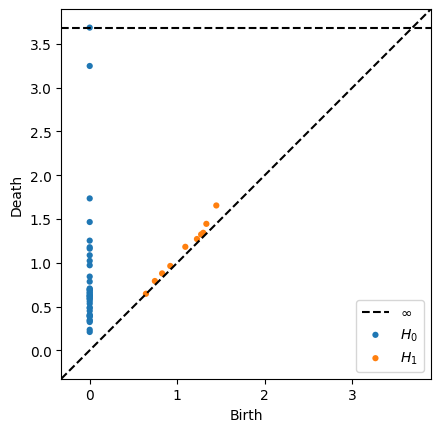

In [73]:
ripsprueba=ripser.ripser(anom12_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 16, Dimensión 5, Stride 1**

In [74]:
plot_point_cloud(embed_anom122_viz)

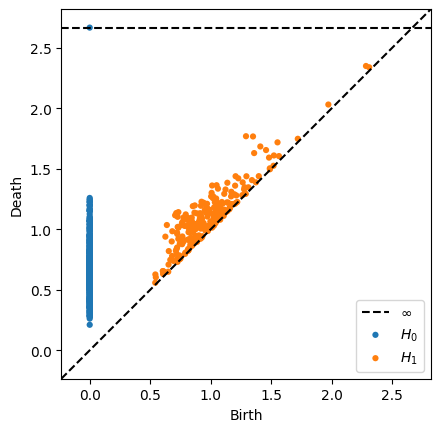

In [75]:
ripsprueba=ripser.ripser(anom12_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 5, Dimensión 2, Stride 1**

In [76]:
plot_point_cloud(anom12_embed3)

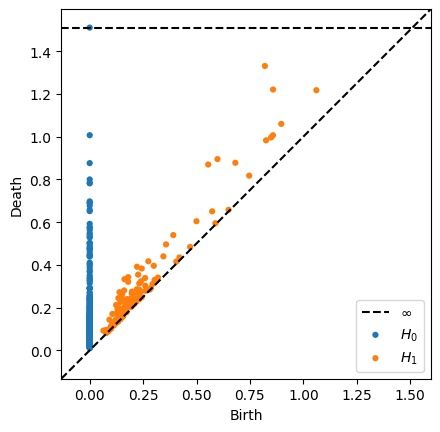

In [77]:
ripsprueba=ripser.ripser(anom12_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Nino 3

**Parametros a probar:**

*   Delay 15, Dimensión 3, Stride 12
* Delay 15, Dimensión 5, Stride 1
* Delay 2, Dimensión 2, Stride 1







In [78]:
#Embedding con Función Auxiliar
#embed_nino3_2 =embed2(sstoi_df["nino3"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino3_3 =embed2(sstoi_df["nino3"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_31 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=15,dimension=3,stride=12,)
nino3_embed1 = embedder_31.fit_transform(sstoi_df['nino3']) #TakensEmbeddingOptimalParameters
embedder_32 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=15,dimension=5,stride=1,)
nino3_embed2 = embedder_32.fit_transform(sstoi_df['nino3']) #Fncion Search
embedder_33 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=2,dimension=2,stride=1,)
nino3_embed3 = embedder_33.fit_transform(sstoi_df['nino3']) #Optimos Locales

#PCA para visualización
#embed_nino32a_viz = pca_viz.fit_transform(embed_nino3_2)
#embed_nino31_viz = pca_viz.fit_transform(nino3_embed1)
embed_nino32_viz = pca_viz.fit_transform(nino3_embed2)

##### Visualizaciones

######**Delay 15, Dimensión 3, Stride 12**

In [79]:
plot_point_cloud(nino3_embed1)

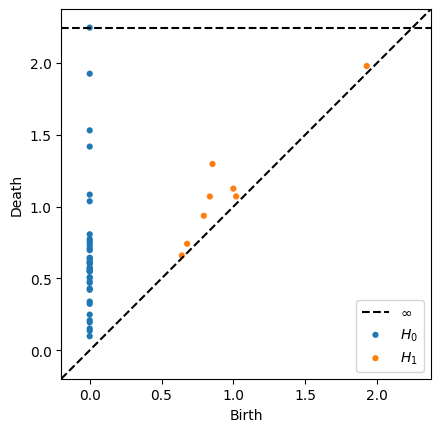

In [80]:
ripsprueba=ripser.ripser(nino3_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 15, Dimensión 5, Stride 1**

In [81]:
plot_point_cloud(embed_nino32_viz)

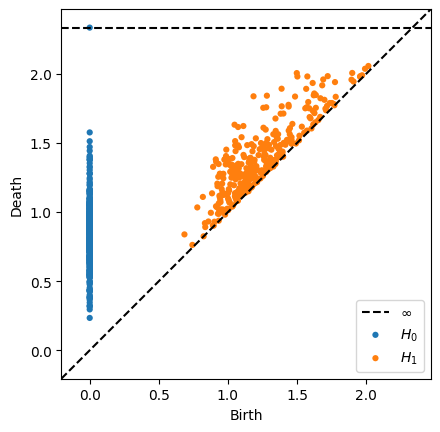

In [82]:
ripsprueba=ripser.ripser(nino3_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 2, Dimensión 2, Stride 1**

In [83]:
plot_point_cloud(nino3_embed3)

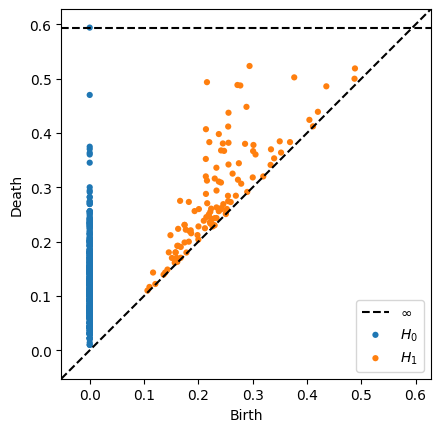

In [84]:
ripsprueba=ripser.ripser(nino3_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Anom 3

**Parametros a probar:**

*   Delay 19, Dimensión 2, Stride 12
* Delay 19, Dimensión 6, Stride 1
* Delay 5, Dimensión 2, Stride 1







In [85]:
#Embedding con Función Auxiliar
#embed_nino3_2 =embed2(sstoi_df["nino3"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino3_3 =embed2(sstoi_df["nino3"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_anom31 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=19,dimension=2,stride=12,)
anom3_embed1 = embedder_anom31.fit_transform(sstoi_df['anom3']) #TakensEmbeddingOptimalParameters
embedder_anom32 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=19,dimension=6,stride=1,)
anom3_embed2 = embedder_anom32.fit_transform(sstoi_df['anom3']) #Fncion Search
embedder_anom33 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=5,dimension=2,stride=1,)
anom3_embed3 = embedder_anom33.fit_transform(sstoi_df['anom3']) #Optimos Locales

#PCA para visualización
#embed_nino32a_viz = pca_viz.fit_transform(embed_nino3_2)
#embed_nino31_viz = pca_viz.fit_transform(nino3_embed1)
embed_anom32_viz = pca_viz.fit_transform(anom3_embed2)

##### Visualizaciones

######**Delay 19, Dimensión 2, Stride 12**

In [86]:
plot_point_cloud(anom3_embed1)

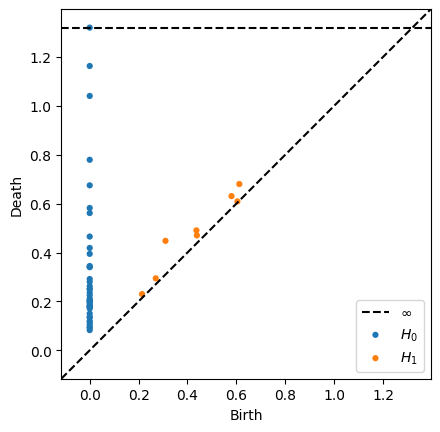

In [87]:
ripsprueba=ripser.ripser(anom3_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 19, Dimensión 6, Stride 1**

In [88]:
plot_point_cloud(embed_anom32_viz)

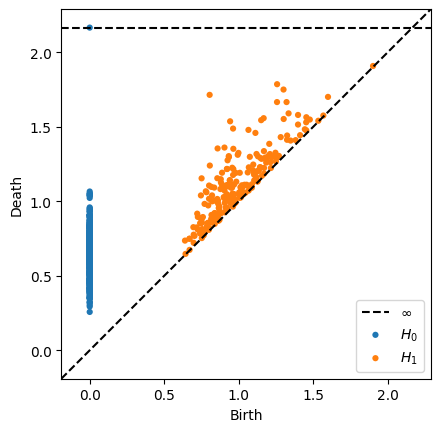

In [89]:
ripsprueba=ripser.ripser(anom3_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 5, Dimensión 2, Stride 1**

In [90]:
plot_point_cloud(anom3_embed3)

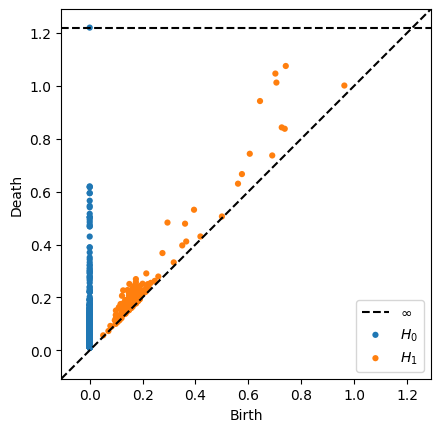

In [91]:
ripsprueba=ripser.ripser(anom3_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Nino 4

**Parametros a probar:**

*   Delay 6, Dimensión 2, Stride 12
* Delay 6, Dimensión 7, Stride 1
* Delay 6, Dimensión 2, Stride 1







In [92]:
#Embedding con Función Auxiliar
#embed_nino4_2 =embed2(sstoi_df["nino4"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino4_3 =embed2(sstoi_df["nino4"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_41 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=6,dimension=2,stride=12,)
nino4_embed1 = embedder_41.fit_transform(sstoi_df['nino4']) #TakensEmbeddingOptimalParameters
embedder_42 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=6,dimension=7,stride=1,)
nino4_embed2 = embedder_42.fit_transform(sstoi_df['nino4']) #Fncion Search
embedder_43 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=6,dimension=2,stride=1,)
nino4_embed3 = embedder_43.fit_transform(sstoi_df['nino4']) #Optimos Locales

#PCA para visualización
#embed_nino42a_viz = pca_viz.fit_transform(embed_nino4_2)
#embed_nino41_viz = pca_viz.fit_transform(nino4_embed1)
embed_nino42_viz = pca_viz.fit_transform(nino4_embed2)

##### Visualizaciones

######**Delay 6, Dimensión 2, Stride 12**

In [93]:
plot_point_cloud(nino4_embed1)

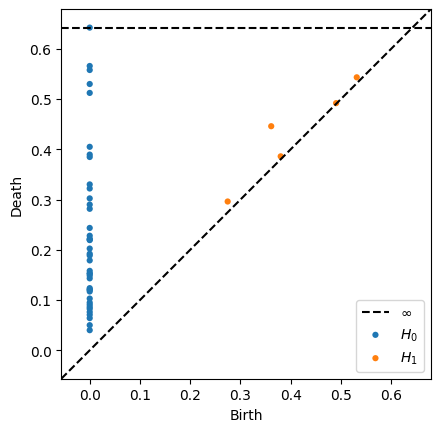

In [94]:
ripsprueba=ripser.ripser(nino4_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 6, Dimensión 7, Stride 1**

In [95]:
plot_point_cloud(embed_nino42_viz)

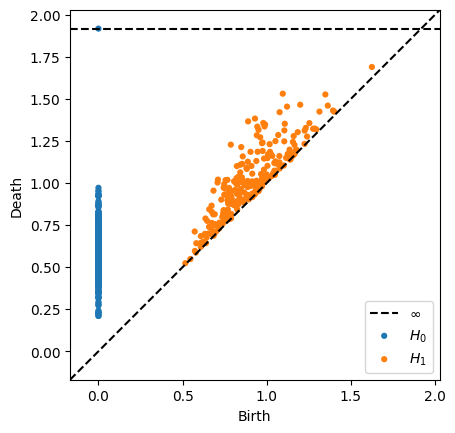

In [96]:
ripsprueba=ripser.ripser(nino4_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 6, Dimensión 2, Stride 1**

In [97]:
plot_point_cloud(nino4_embed3)

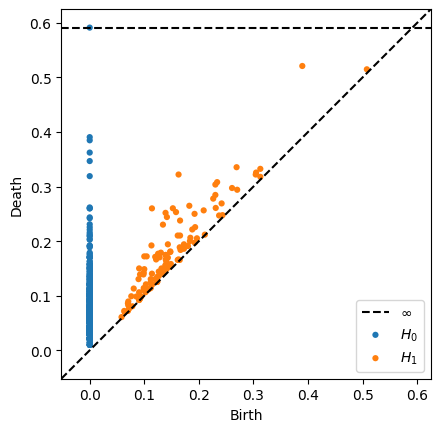

In [98]:
ripsprueba=ripser.ripser(nino4_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Anom 4

**Parametros a probar:**

* Delay 12, Dimensión 3, Stride 12
* Delay 12, Dimensión 5, Stride 1
* Delay 4, Dimensión 2, Stride 1







In [99]:
#Embedding con Función Auxiliar
#embed_nino4_2 =embed2(sstoi_df["nino4"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino4_3 =embed2(sstoi_df["nino4"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_anom41 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=12,dimension=3,stride=12,)
anom4_embed1 = embedder_anom41.fit_transform(sstoi_df['anom4']) #TakensEmbeddingOptimalParameters
embedder_anom42 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=12,dimension=5,stride=1,)
anom4_embed2 = embedder_anom42.fit_transform(sstoi_df['anom4']) #Fncion Search
embedder_anom43 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=4,dimension=2,stride=1,)
anom4_embed3 = embedder_anom43.fit_transform(sstoi_df['anom4']) #Optimos Locales

#PCA para visualización
#embed_nino42a_viz = pca_viz.fit_transform(embed_nino4_2)
#embed_nino41_viz = pca_viz.fit_transform(nino4_embed1)
embed_anom42_viz = pca_viz.fit_transform(anom4_embed2)

##### Visualizaciones

######**Delay 12, Dimensión 3, Stride 12**

In [100]:
plot_point_cloud(anom4_embed1)

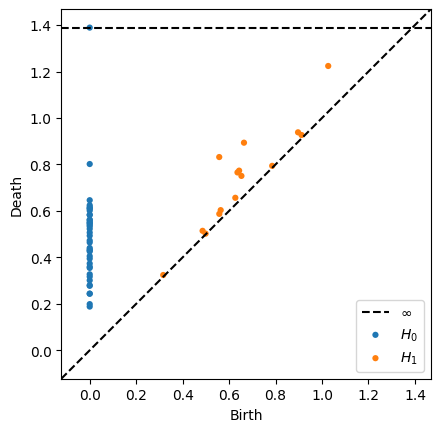

In [101]:
ripsprueba=ripser.ripser(anom4_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 12, Dimensión 5, Stride 1**

In [102]:
plot_point_cloud(embed_anom42_viz)

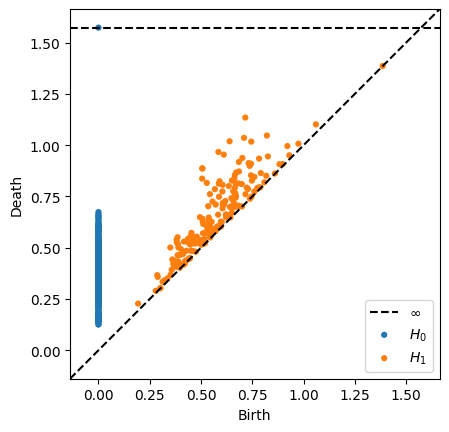

In [103]:
ripsprueba=ripser.ripser(anom4_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 4, Dimensión 2, Stride 1**

In [104]:
plot_point_cloud(anom4_embed3)

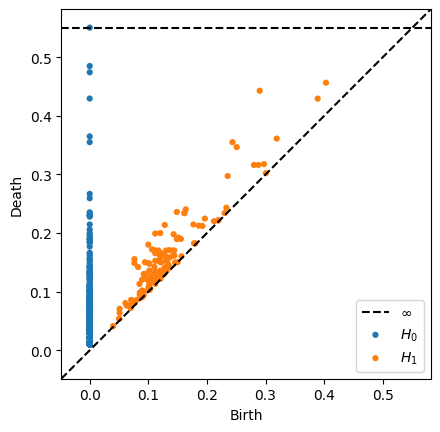

In [105]:
ripsprueba=ripser.ripser(anom4_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Nino 3_4

**Parametros a probar:**

*   Delay 17, Dimensión 3, Stride 12
* Delay 17, Dimensión 8, Stride 1
* Delay 4, Dimensión 2, Stride 1







In [106]:
#Embedding con Función Auxiliar
#embed_nino34_2 =embed2(sstoi_df["nino3_4"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino34_3 =embed2(sstoi_df["nino3_4"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_341 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=17,dimension=3,stride=12,)
nino34_embed1 = embedder_341.fit_transform(sstoi_df['nino3_4']) #TakensEmbeddingOptimalParameters
embedder_342 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=17,dimension=8,stride=1,)
nino34_embed2 = embedder_342.fit_transform(sstoi_df['nino3_4']) #Fncion Search
embedder_343 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=4,dimension=2,stride=1,)
nino34_embed3 = embedder_343.fit_transform(sstoi_df['nino3_4']) #Optimos Locales

#PCA para visualización
#embed_nino341a_viz = pca_viz.fit_transform(embed_nino34_2)
#embed_nino341_viz = pca_viz.fit_transform(nino34_embed1)
embed_nino342_viz = pca_viz.fit_transform(nino34_embed2)

##### Visualizaciones

######**Delay 17, Dimensión 3, Stride 12**

In [107]:
plot_point_cloud(nino34_embed1)

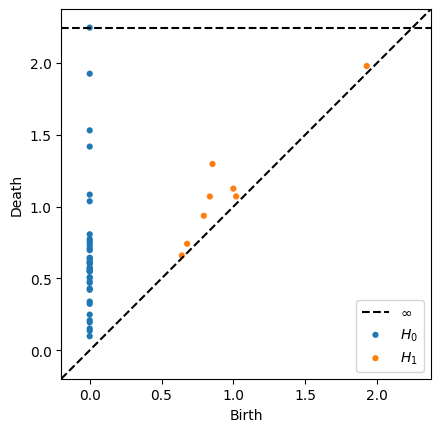

In [108]:
ripsprueba=ripser.ripser(nino3_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 17, Dimensión 8, Stride 1**

In [109]:
plot_point_cloud(embed_nino342_viz)

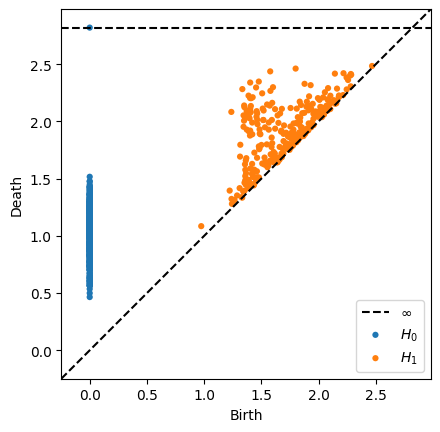

In [110]:
ripsprueba=ripser.ripser(nino34_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 4, Dimensión 2, Stride 1**

In [111]:
plot_point_cloud(nino34_embed3)

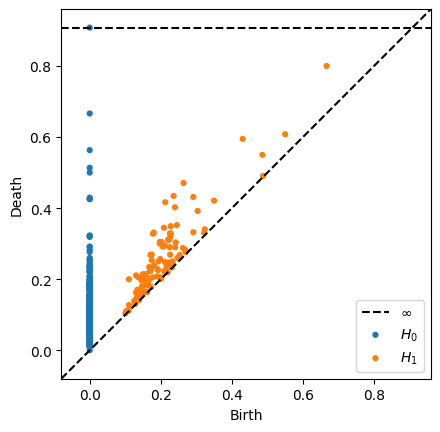

In [112]:
ripsprueba=ripser.ripser(nino34_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

#### Anom 3_4

**Parametros a probar:**

*   Delay 14, Dimensión 2, Stride 12
* Delay 14, Dimensión 6, Stride 1
* Delay 2, Dimensión 2, Stride 1







In [113]:
#Embedding con Función Auxiliar
#embed_nino34_2 =embed2(sstoi_df["nino3_4"],dimemb=8, time_delay=3) #Fncion Search
#embed_nino34_3 =embed2(sstoi_df["nino3_4"],dimemb=2, time_delay=5) #Optimos Locales

#Embeddinf con Librería
embedder_anom341 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=14,dimension=2,stride=12,)
anom34_embed1 = embedder_anom341.fit_transform(sstoi_df['anom3_4']) #TakensEmbeddingOptimalParameters
embedder_anom342 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=17,dimension=8,stride=1,)
anom34_embed2 = embedder_anom342.fit_transform(sstoi_df['anom3_4']) #Fncion Search
embedder_anom343 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=4,dimension=2,stride=1,)
anom34_embed3 = embedder_anom343.fit_transform(sstoi_df['anom3_4']) #Optimos Locales

#PCA para visualización
#embed_nino341a_viz = pca_viz.fit_transform(embed_nino34_2)
#embed_nino341_viz = pca_viz.fit_transform(nino34_embed1)
embed_anom342_viz = pca_viz.fit_transform(anom34_embed2)

##### Visualizaciones

######**Delay 14, Dimensión 2, Stride 12**

In [114]:
plot_point_cloud(anom34_embed1)

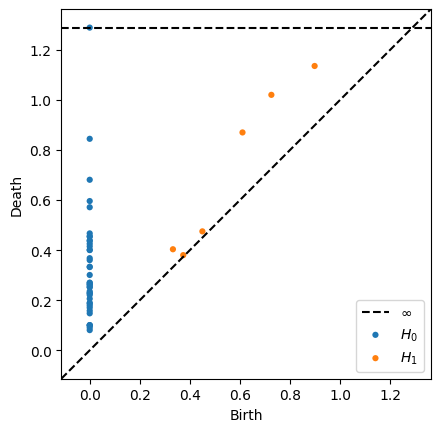

In [115]:
ripsprueba=ripser.ripser(anom34_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

###### **Delay 14, Dimensión 6, Stride 1**

In [116]:
plot_point_cloud(embed_anom342_viz)

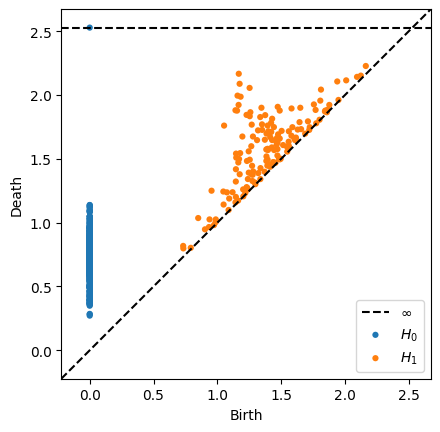

In [117]:
ripsprueba=ripser.ripser(anom34_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

######**Delay 2, Dimensión 2, Stride 1**

In [118]:
plot_point_cloud(anom34_embed3)

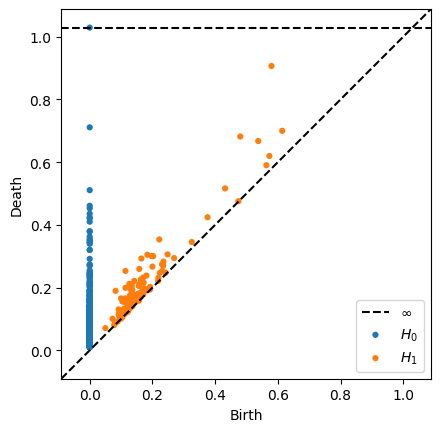

In [119]:
ripsprueba=ripser.ripser(anom34_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

# Denoising 

## Fourier transform denoiser

In [120]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [121]:
sstoi_df

nino1+2  anom1+2  nino3  anom3  nino4  anom4  nino3_4  anom3_4
date                                                                      
1982-01-01    24.28    -0.24  25.84   0.17  28.01  -0.21    26.65     0.08
1982-02-01    25.38    -0.72  26.26  -0.11  27.99  -0.11    26.54    -0.20
1982-03-01    25.22    -1.38  26.92  -0.25  28.18  -0.05    27.09    -0.14
1982-04-01    24.57    -1.16  27.52  -0.05  28.61   0.10    27.83     0.02
1982-05-01    24.00    -0.62  27.70   0.49  29.19   0.40    28.37     0.49
...             ...      ...    ...    ...    ...    ...      ...      ...
2022-12-01    22.54    -0.30  24.48  -0.78  27.71  -0.73    25.81    -0.84
2023-01-01    24.27    -0.24  25.17  -0.50  27.62  -0.60    25.88    -0.69
2023-02-01    26.80     0.71  26.25  -0.13  27.58  -0.52    26.29    -0.44
2023-03-01    28.12     1.52  27.52   0.36  28.09  -0.14    27.23    -0.01
2023-04-01    28.18     2.45  28.02   0.44  28.81   0.30    27.99     0.19

[496 rows x 8 columns]

In [122]:
nino3_denoised =fft_denoiser(sstoi_df['nino3'], 0.1)
nino4_denoised =fft_denoiser(sstoi_df['nino4'], 0.1)
nino34_denoised =fft_denoiser(sstoi_df['nino3_4'], 0.1)
denoised_df=sstoi_df[['nino1+2', 'nino3', 'nino4', 'nino3_4']]

denoised_df['nino3_d'] = nino3_denoised.tolist()
denoised_df['nino34_d'] = nino34_denoised.tolist()
denoised_df['nino4_d'] = nino4_denoised.tolist()

denoised_df

<ipython-input-122-7a2c71d30c9d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-122-7a2c71d30c9d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-122-7a2c71d30c9d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



nino1+2  nino3  nino4  nino3_4    nino3_d   nino34_d    nino4_d
date                                                                       
1982-01-01    24.28  25.84  28.01    26.65  26.451847  27.020275  28.251870
1982-02-01    25.38  26.26  27.99    26.54  26.283054  26.825357  28.292962
1982-03-01    25.22  26.92  28.18    27.09  26.836361  27.096313  28.423341
1982-04-01    24.57  27.52  28.61    27.83  27.556229  27.796576  28.676809
1982-05-01    24.00  27.70  29.19    28.37  27.501856  28.202228  28.930653
...             ...    ...    ...      ...        ...        ...        ...
2022-12-01    22.54  24.48  27.71    25.81  24.372256  25.769974  27.730194
2023-01-01    24.27  25.17  27.62    25.88  25.120880  25.958627  27.671080
2023-02-01    26.80  26.25  27.58    26.29  26.350695  26.468353  27.746854
2023-03-01    28.12  27.52  28.09    27.23  27.539518  27.136609  27.955951
2023-04-01    28.18  28.02  28.81    27.99  27.419027  27.389012  28.159354

[496 rows x 7 columns]

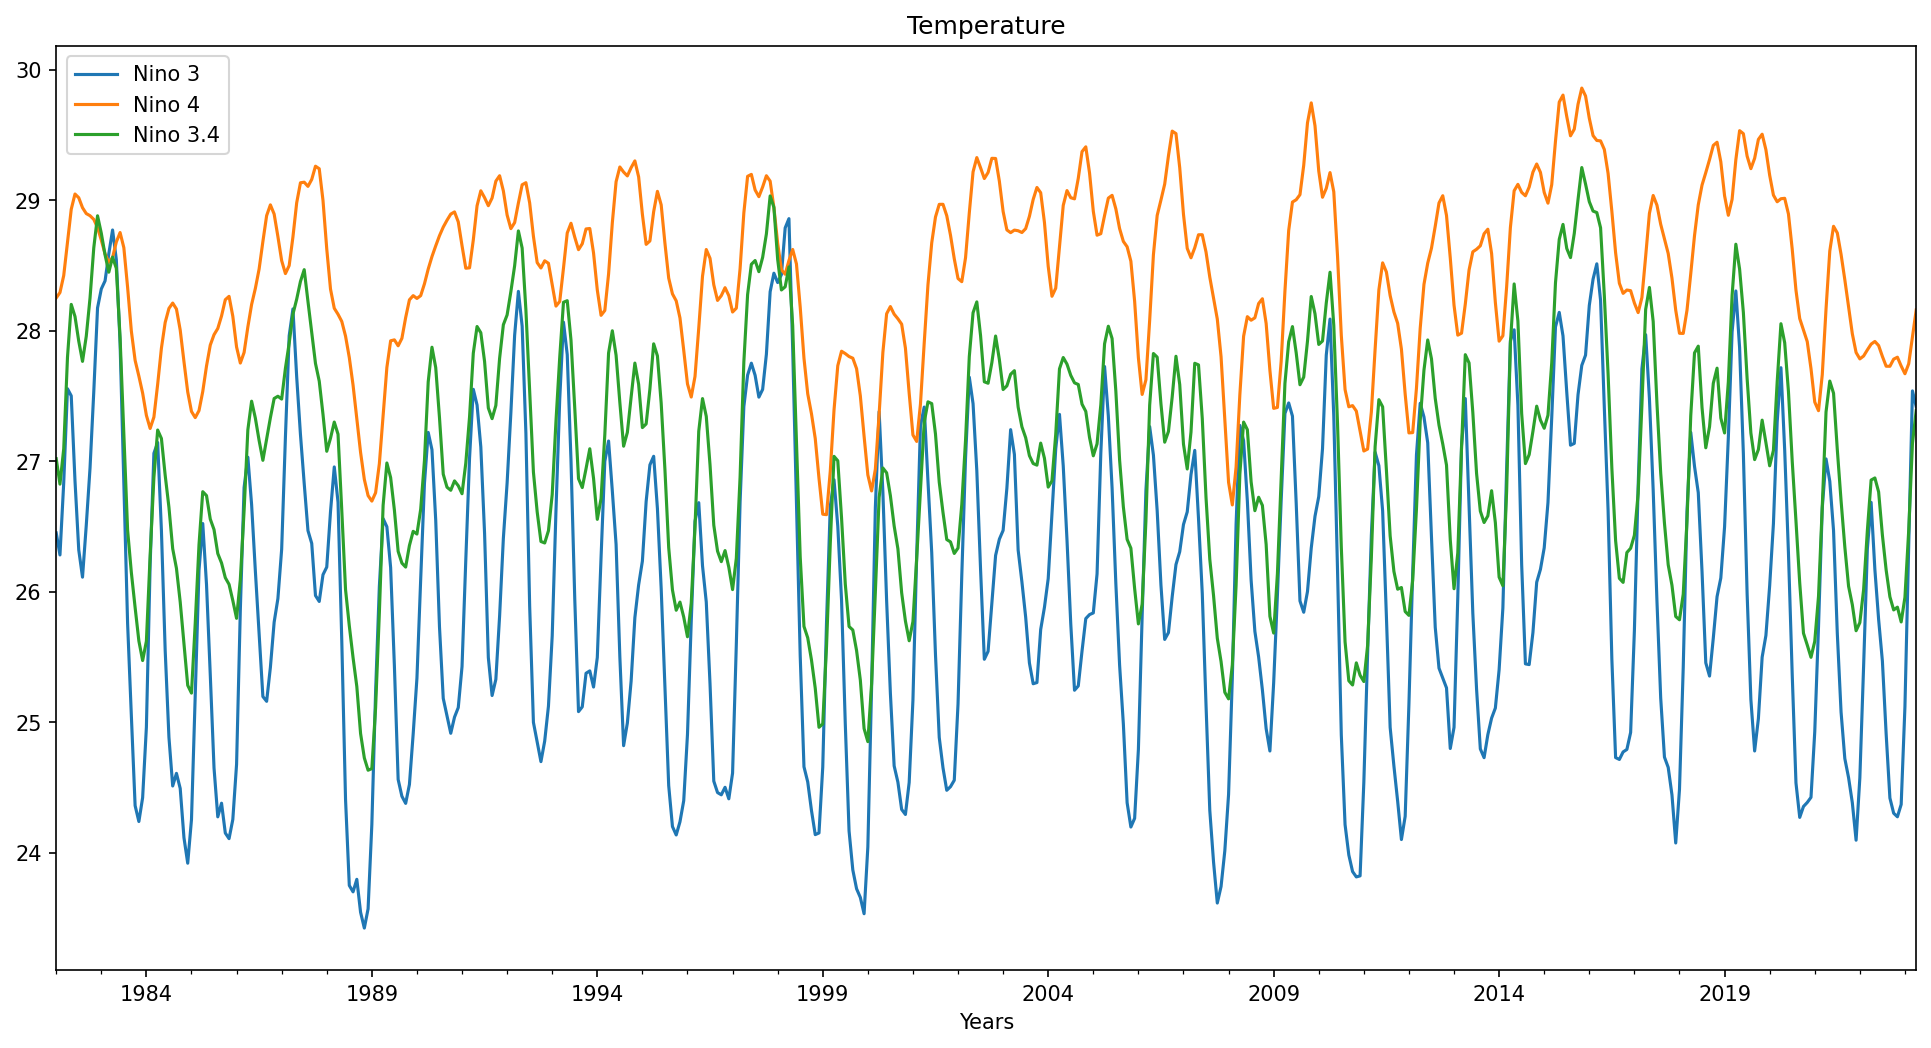

In [123]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
#denoised_df['nino1+2_d'].plot(label='Nino 1+2', color='orange')
denoised_df['nino3_d'].plot(label='Nino 3')
denoised_df['nino4_d'].plot(label='Nino 4')
denoised_df['nino34_d'].plot(label='Nino 3.4')
  
# adding title to the plot
plt.title('Temperature')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend()

## KNN Denoiser

In [124]:
from sklearn.neighbors import KNeighborsRegressor

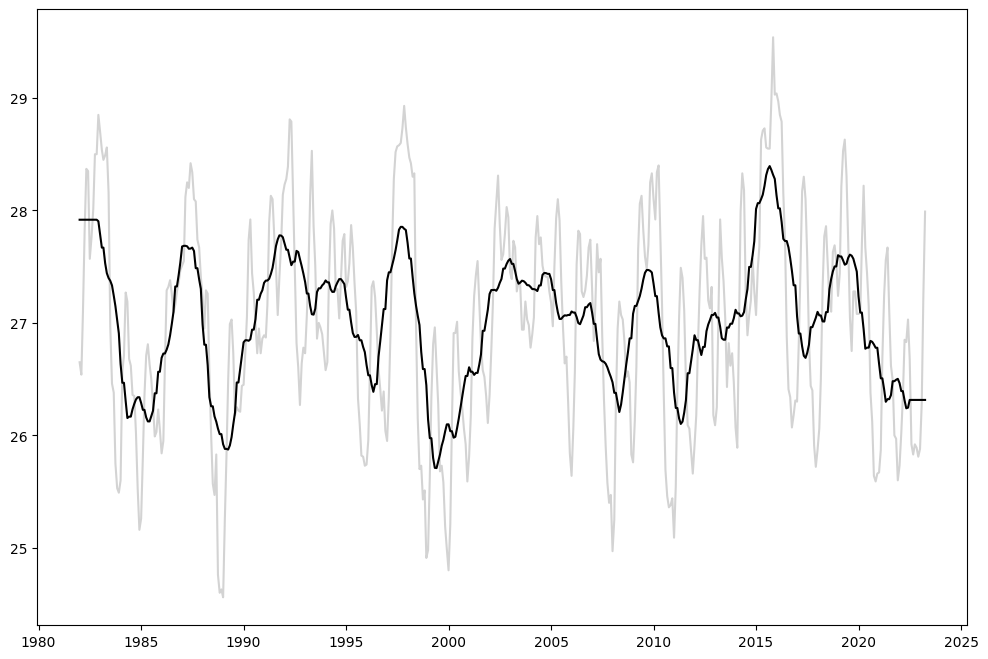

In [125]:
clf1 = KNeighborsRegressor(n_neighbors=20)
clf1.fit(sstoi_df.index.values[:, np.newaxis], 
        sstoi_df['nino3_4'])

y_pred1 = clf1.predict(sstoi_df.index.values[:, np.newaxis])

plt.figure(figsize=(12,8))
plt.plot(sstoi_df['nino3_4'],color='lightgray')
plt.plot(sstoi_df.index,y_pred1, color='black')
#pd.Series(y_pred).plot(color='black', figsize=(12, 8))

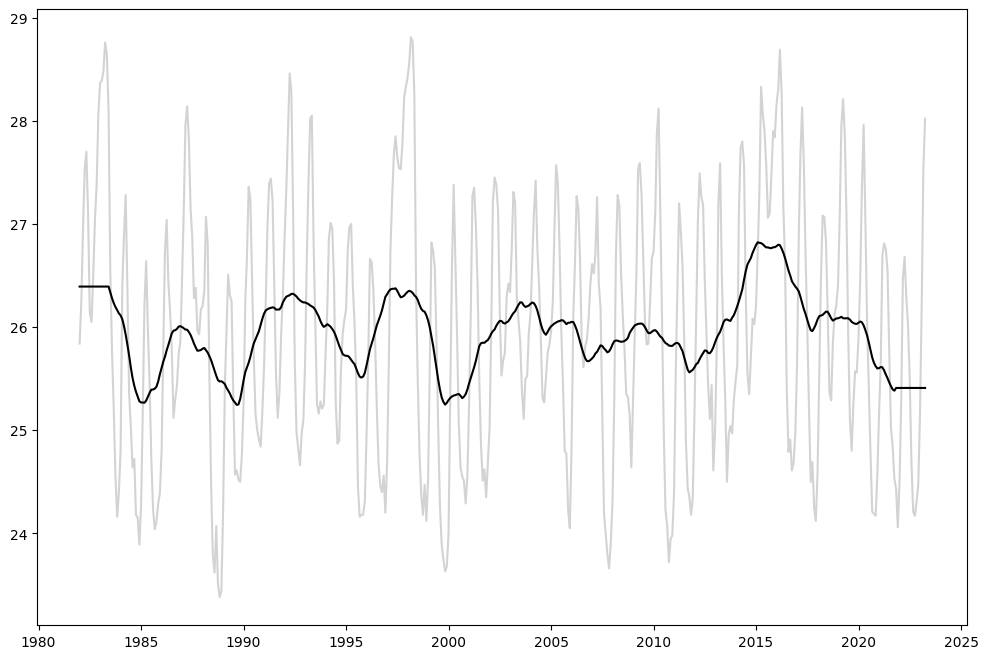

In [126]:
clf2 = KNeighborsRegressor(n_neighbors=35)
clf2.fit(sstoi_df.index.values[:, np.newaxis], 
        sstoi_df['nino3'])

y_pred2 = clf2.predict(sstoi_df.index.values[:, np.newaxis])

plt.figure(figsize=(12,8))
plt.plot(sstoi_df['nino3'],color='lightgray')
plt.plot(sstoi_df.index,y_pred2, color='black')
#pd.Series(y_pred).plot(color='black', figsize=(12, 8))

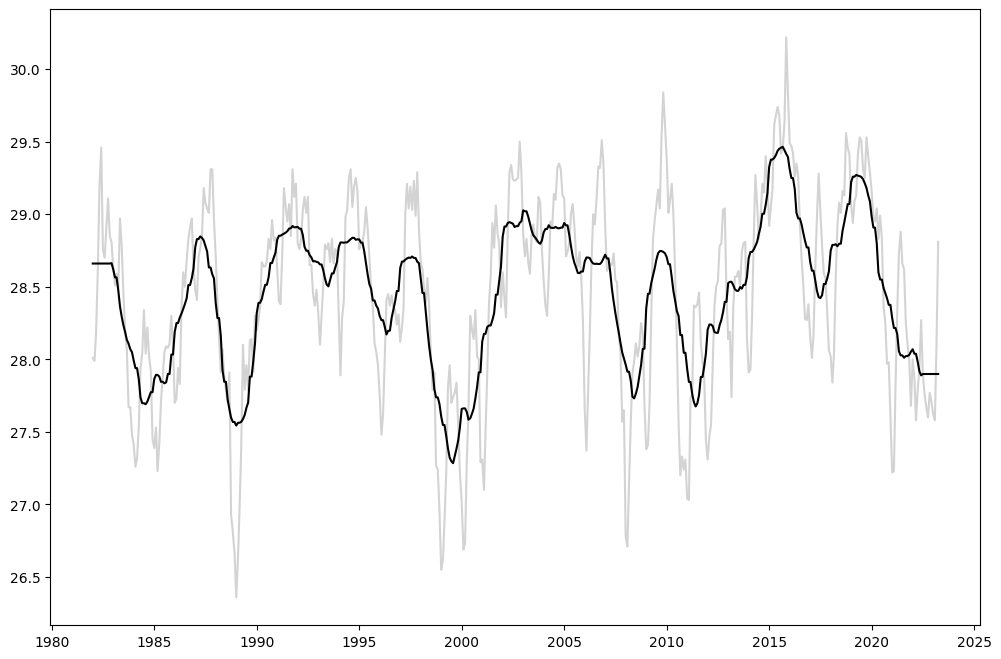

In [127]:
clf3 = KNeighborsRegressor(n_neighbors=20)
clf3.fit(sstoi_df.index.values[:, np.newaxis], 
        sstoi_df['nino4'])

y_pred3 = clf3.predict(sstoi_df.index.values[:, np.newaxis])

plt.figure(figsize=(12,8))
plt.plot(sstoi_df['nino4'],color='lightgray')
plt.plot(sstoi_df.index,y_pred3, color='black')
#pd.Series(y_pred).plot(color='black', figsize=(12, 8))

In [128]:
df_denoised_knn= pd.DataFrame(index=sstoi_df.index)
#knn_denoised_df=pd.DataFrame(y_pred3, columns=['nino4'])
df_denoised_knn['nino3'] = y_pred2.tolist()
df_denoised_knn['nino3_4'] = y_pred1.tolist()
df_denoised_knn['nino4'] = y_pred3.tolist()
df_denoised_knn

nino3  nino3_4    nino4
date                                   
1982-01-01  26.392857  27.9175  28.6605
1982-02-01  26.392857  27.9175  28.6605
1982-03-01  26.392857  27.9175  28.6605
1982-04-01  26.392857  27.9175  28.6605
1982-05-01  26.392857  27.9175  28.6605
...               ...      ...      ...
2022-12-01  25.409714  26.3150  27.8990
2023-01-01  25.409714  26.3150  27.8990
2023-02-01  25.409714  26.3150  27.8990
2023-03-01  25.409714  26.3150  27.8990
2023-04-01  25.409714  26.3150  27.8990

[496 rows x 3 columns]

### Takens Embedding

In [129]:
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_knn['nino3'])
print('Nino3')
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_, '\n')

print('Nino3_4')
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_knn['nino3_4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_,  '\n')

print('Nino4')
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_knn['nino4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

Nino3
El delay encontrado es  18
La dimensión encontrada es  15 

Nino3_4
El delay encontrado es  18
La dimensión encontrada es  12 

Nino4
El delay encontrado es  18
La dimensión encontrada es  13


In [130]:
embedder_knn1 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=18,dimension=12,stride=1,)
knn_embed1 = embedder_knn1.fit_transform(df_denoised_knn['nino3']) 
embedder_knn2 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=18,dimension=12,stride=1,)
knn_embed2 = embedder_knn2.fit_transform(df_denoised_knn['nino3_4'])
embedder_knn3= SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=18,dimension=13,stride=1,)
knn_embed3 = embedder_knn3.fit_transform(df_denoised_knn['nino4']) 

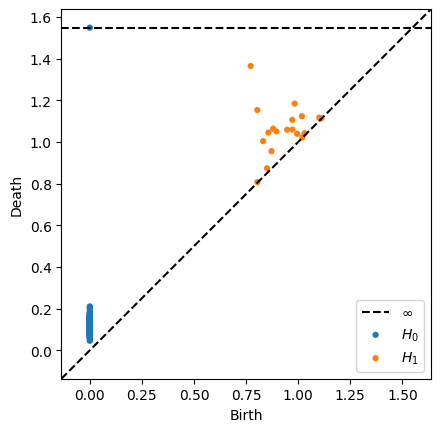

In [131]:
ripsprueba=ripser.ripser(knn_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

In [132]:
knn_embed1_viz = pca_viz.fit_transform(knn_embed1)
plot_point_cloud(knn_embed1_viz)

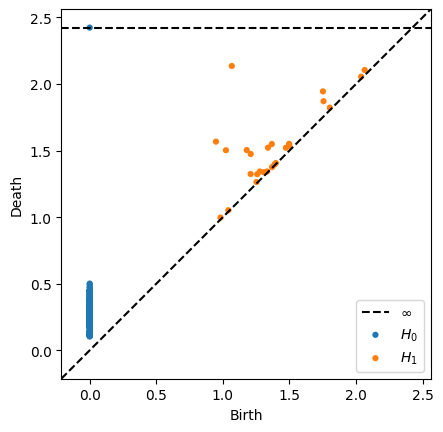

In [133]:
ripsprueba=ripser.ripser(knn_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

In [134]:
knn_embed2_viz = pca_viz.fit_transform(knn_embed2)
plot_point_cloud(knn_embed2_viz)

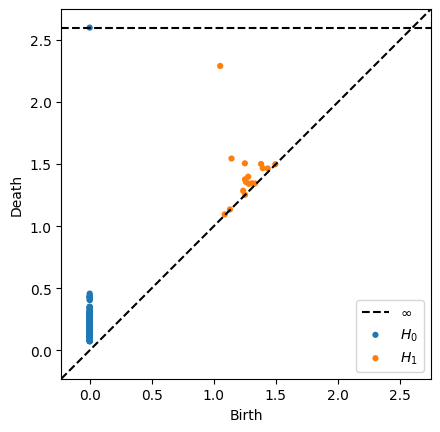

In [135]:
ripsprueba=ripser.ripser(knn_embed3)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

In [136]:
knn_embed3_viz = pca_viz.fit_transform(knn_embed3)
plot_point_cloud(knn_embed3_viz)

## Convolutional

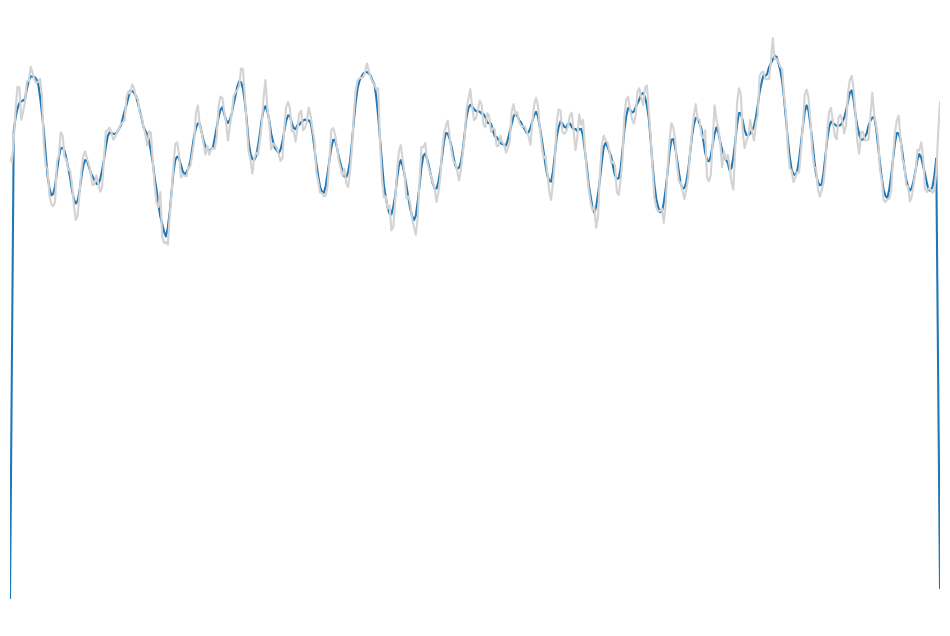

In [137]:
from scipy import signal

sstoi_df_na=sstoi_df[['nino3', 'nino4', 'nino3_4']]

def apply_convolution(sig, window):
    #conv = np.repeat([0., 1., 0.], window)
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(sig, conv, mode='same') / window
    return filtered

df_denoised_conv = sstoi_df_na.apply(lambda srs: apply_convolution(srs, 5))
ax=df_denoised_conv['nino3_4'].plot(figsize=(12, 8))
sstoi_df_na['nino3_4'].plot(ax=ax, color='lightgray')
plt.axis('off'); pass

In [138]:
df_denoised_conv

nino3   nino4  nino3_4
date                               
1982-01-01  15.804  16.836   16.056
1982-02-01  21.308  22.558   21.622
1982-03-01  26.848  28.396   27.296
1982-04-01  27.100  28.686   27.636
1982-05-01  27.076  28.840   27.842
...            ...     ...      ...
2022-12-01  24.876  27.656   25.958
2023-01-01  25.546  27.754   26.220
2023-02-01  26.288  27.962   26.640
2023-03-01  21.392  22.420   21.478
2023-04-01  16.358  16.896   16.302

[496 rows x 3 columns]

In [139]:
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_conv['nino3'])
print('Nino3')
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_, '\n')

print('Nino3_4')
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_conv['nino3_4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_,  '\n')

print('Nino4')
nino1_2_embedded = embedder_periodic.fit_transform(df_denoised_conv['nino4'])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimensión encontrada es ", embedder_periodic.dimension_)

Nino3
El delay encontrado es  8
La dimensión encontrada es  5 

Nino3_4
El delay encontrado es  21
La dimensión encontrada es  6 

Nino4
El delay encontrado es  19
La dimensión encontrada es  14


In [140]:
#Embeddinf con Librería
embedder_conv1 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=8,dimension=5,stride=1,)
conv_embed1 = embedder_conv1.fit_transform(df_denoised_conv['nino3']) 
embedder_conv2 = SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=21,dimension=6,stride=1,)
conv_embed2 = embedder_conv2.fit_transform(df_denoised_conv['nino3_4'])
embedder_conv3= SingleTakensEmbedding(parameters_type="fixed",n_jobs=None,time_delay=19,dimension=14,stride=1,)
conv_embed3 = embedder_conv3.fit_transform(df_denoised_conv['nino4']) 

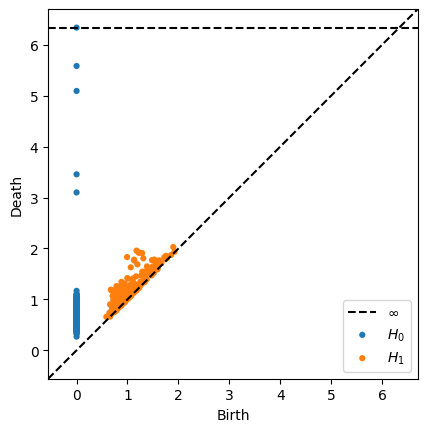

In [141]:
ripsprueba=ripser.ripser(conv_embed1)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

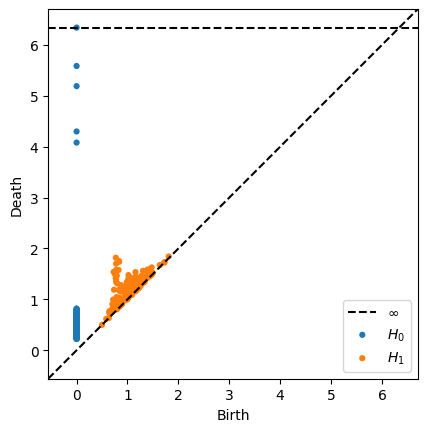

In [142]:
ripsprueba=ripser.ripser(conv_embed2)['dgms']
persim.plot_diagrams(
    ripsprueba, 
    show=True)

# Bottleneck distance Dataset/Denoised

# ARIMA

## Nino 1+2

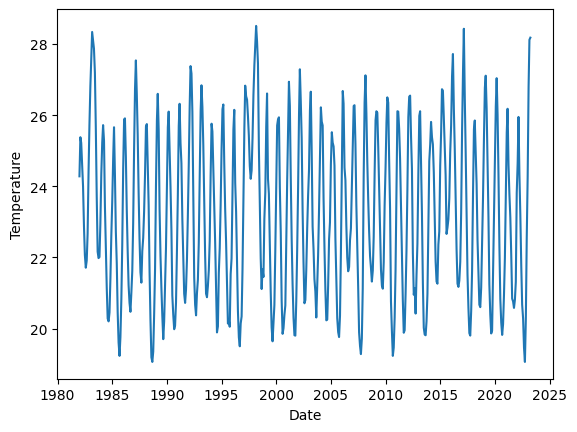

In [143]:
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(sstoi_df['nino1+2'])

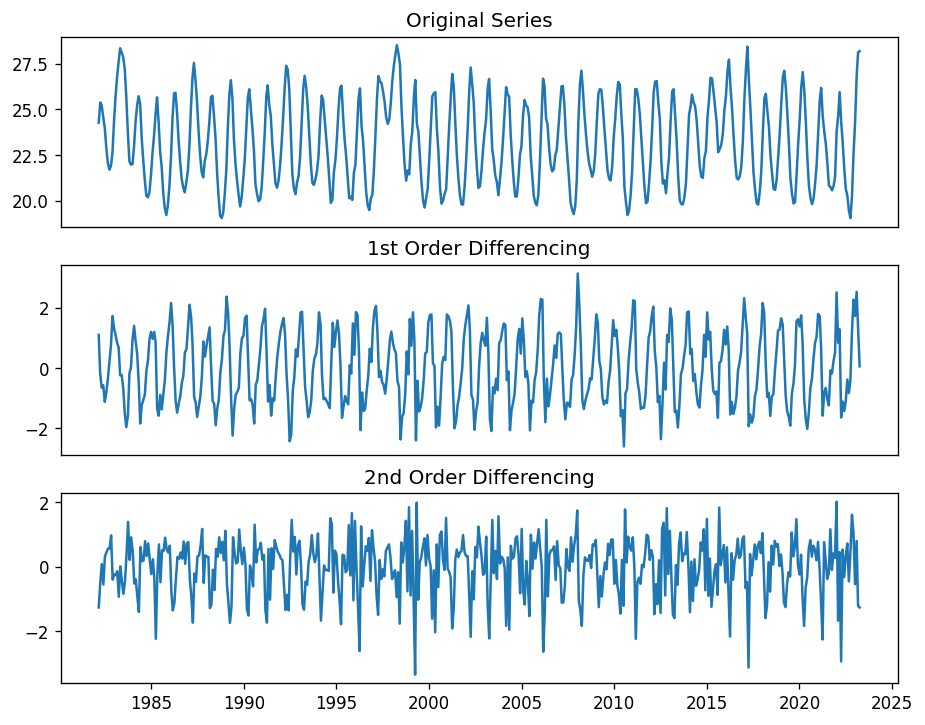

p-value:  1.7848483201583044e-09
p-value:  1.8573795100576946e-11
p-value:  3.237305517473054e-30


In [144]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(sstoi_df['nino1+2']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(sstoi_df['nino1+2'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(sstoi_df['nino1+2'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

resultd0_12 = adfuller(sstoi_df['nino1+2'].dropna())
print('p-value: ', resultd0_12[1])

resultd1_12 = adfuller(sstoi_df['nino1+2'].diff().dropna())
print('p-value: ', resultd1_12[1])

resultd2_12 = adfuller(sstoi_df['nino1+2'].diff().diff().dropna())
print('p-value: ', resultd2_12[1])

Determinamos que d = 0, debido a que no necesitamos diferenciar para que los datos sean estacionarios

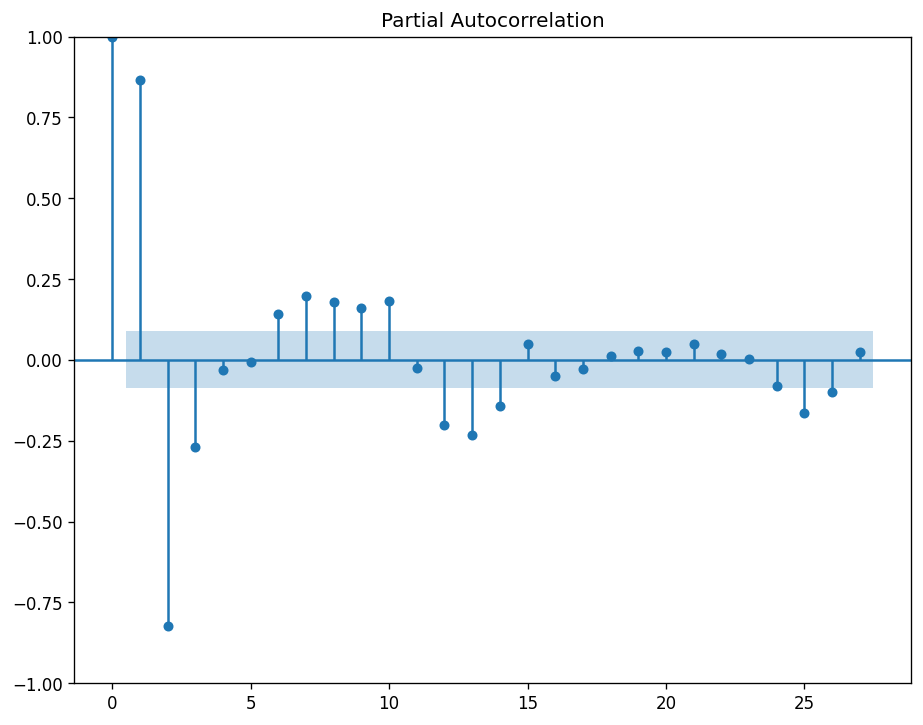

In [145]:
plot_pacf(sstoi_df['nino1+2'].dropna(), method = 'ywm')
plt.show()

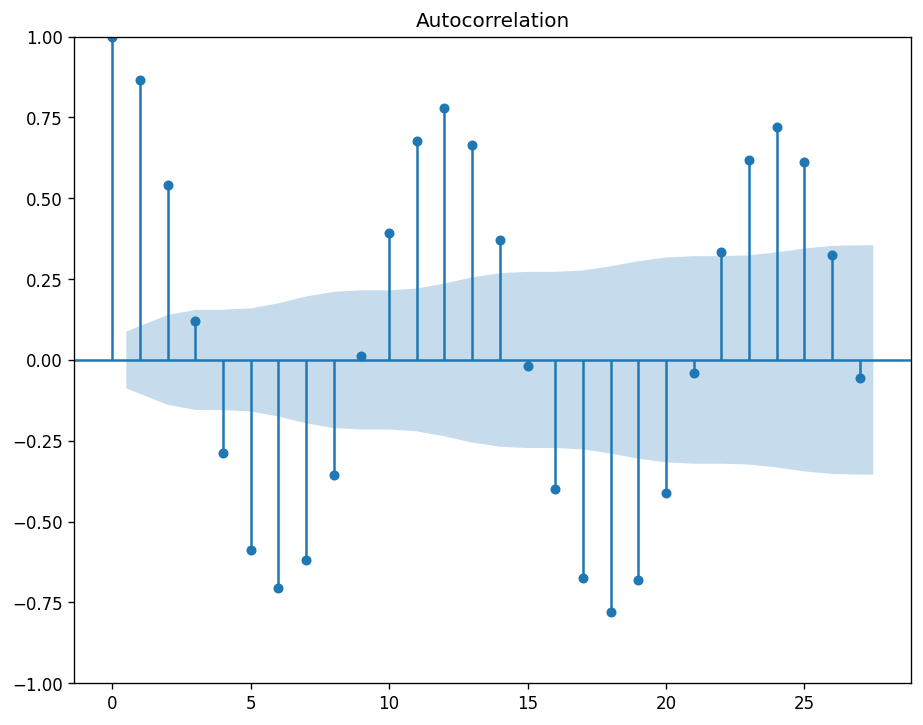

In [146]:
plot_acf(sstoi_df['nino1+2'].dropna())
plt.show()

Vemos que hay 15 lags extremadamente alejados del threshold, asi que determinamos que q = 15

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                nino1+2   No. Observations:                  472
Model:                ARIMA(2, 0, 15)   Log Likelihood                -327.108
Date:                Wed, 07 Jun 2023   AIC                            692.217
Time:                        17:04:21   BIC                            771.199
Sample:                    01-01-1982   HQIC                           723.285
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2613      0.173    134.359      0.000      22.922      23.601
ar.L1          1.7310      0.001   1163.913      0.000       1.728       1.734
ar.L2         -0.9986      0.001   -711.816      0.0

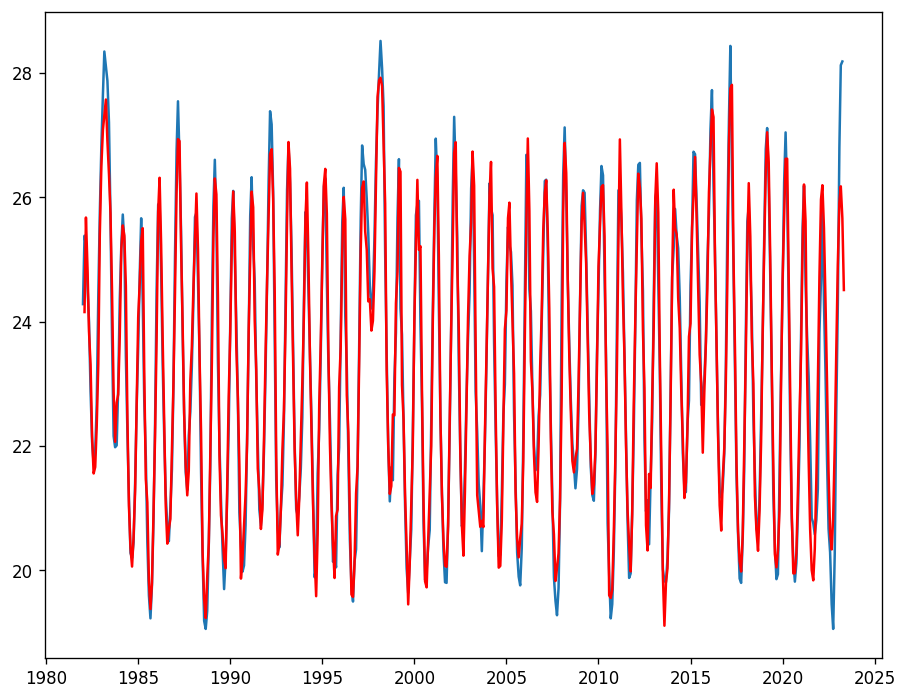

In [147]:
model_12 = ARIMA(sstoi_df['nino1+2'][:472], order=(2,0,15), missing = 'drop')
results_12 = model_12.fit()
print(results_12.summary())

plt.plot(sstoi_df['nino1+2'])
plt.plot(results_12.predict(1,496), color='red')

In [148]:
y_pred = pd.Series(results_12.predict(472,496))
y_true = sstoi_df['nino1+2'][472:]

n=np.array(sstoi_df['nino1+2'][:472]).shape[0]
d=np.abs(np.diff(np.array(sstoi_df['nino1+2'][:472]))).sum()/(n-1)

errors = np.abs(y_true - y_pred)

MAPE = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
MASE = errors.mean()/d

print('El mean absolute scaled error (MASE) es: ', MASE, ' y el Mean absolute percentage error (MAPE) es :', MAPE)

El mean absolute scaled error (MASE) es:  1.0765405269899742  y el Mean absolute percentage error (MAPE) es : 0.048182057710190296


## Nino 3

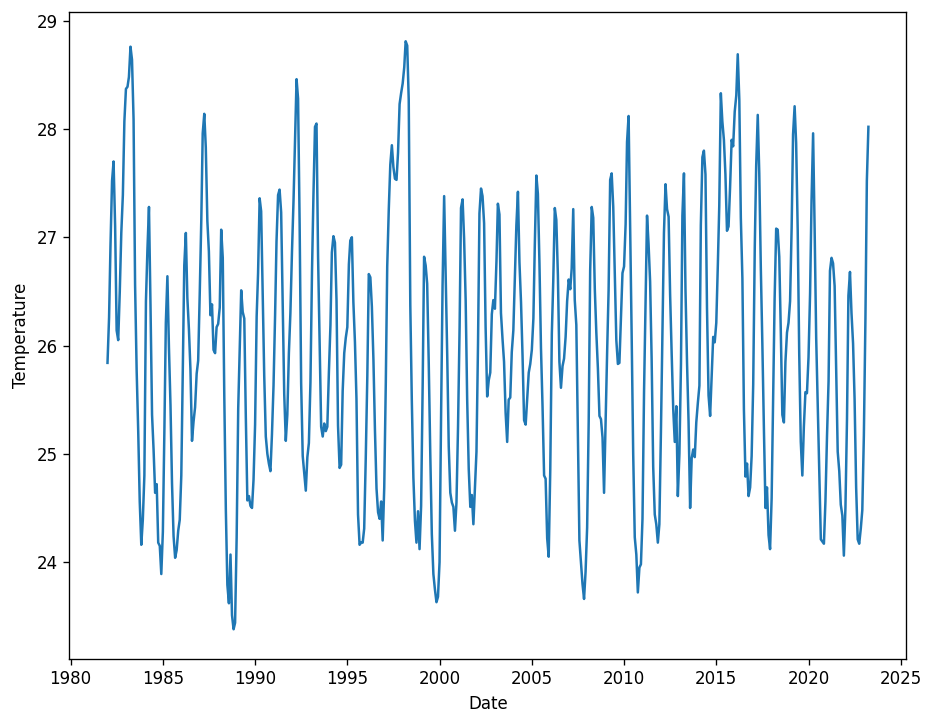

In [149]:
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(sstoi_df['nino3'])

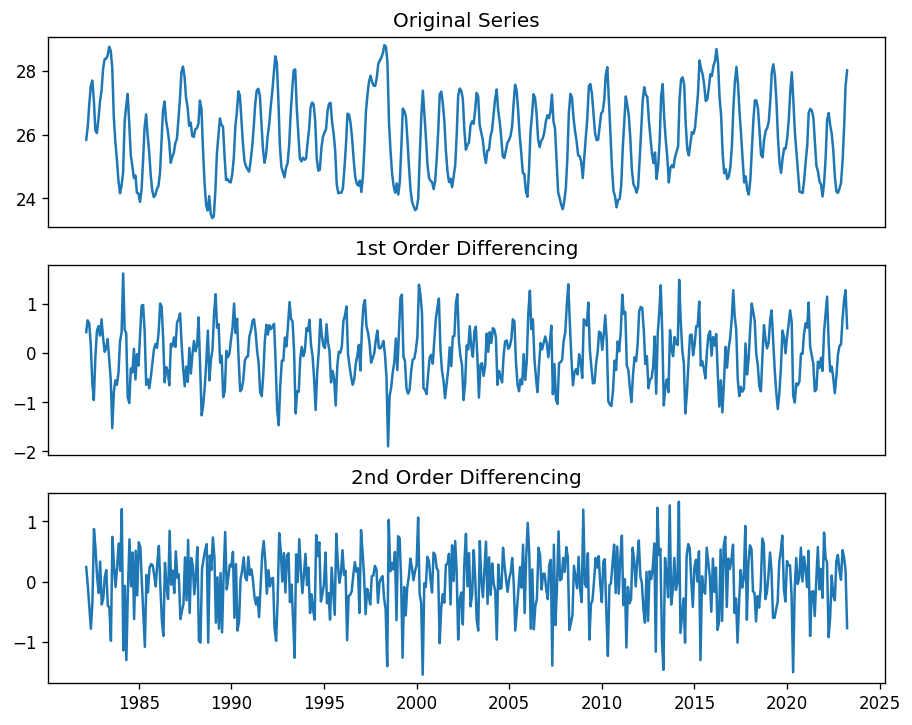

p-value:  1.4026669909648678e-07
p-value:  3.030945336326289e-12
p-value:  1.785982041739342e-16


In [150]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(sstoi_df['nino3']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(sstoi_df['nino3'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(sstoi_df['nino3'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

resultd0_3 = adfuller(sstoi_df['nino3'].dropna())
print('p-value: ', resultd0_3[1])

resultd1_3 = adfuller(sstoi_df['nino3'].diff().dropna())
print('p-value: ', resultd1_3[1])

resultd2_3 = adfuller(sstoi_df['nino3'].diff().diff().dropna())
print('p-value: ', resultd2_3[1])

Determinamos que d = 0, debido a que no necesitamos diferenciar para que los datos sean estacionarios

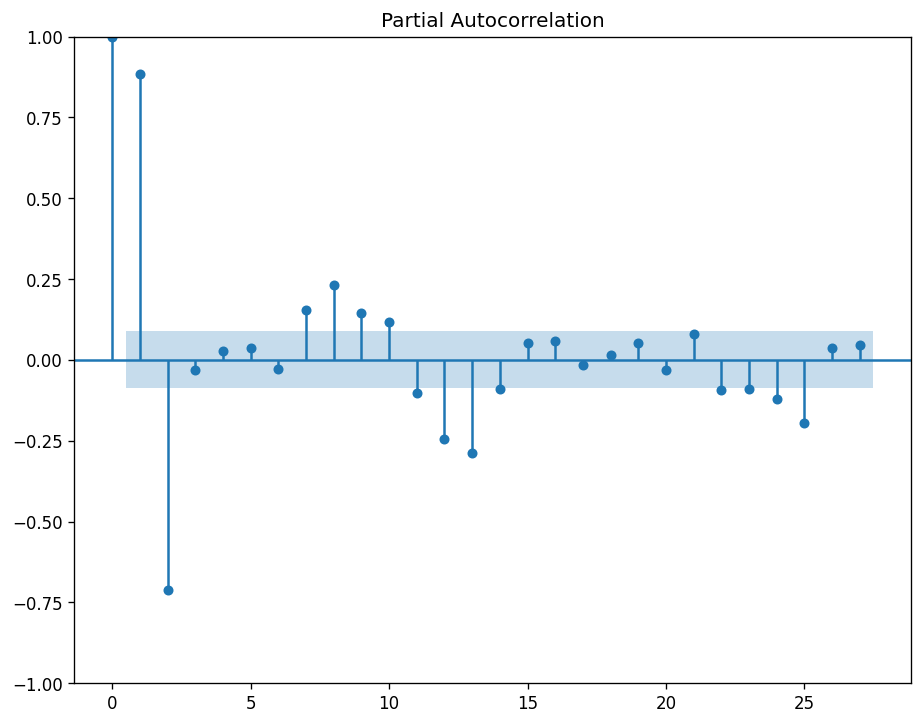

In [151]:
plot_pacf(sstoi_df['nino3'].dropna(), method = 'ywm')
plt.show()

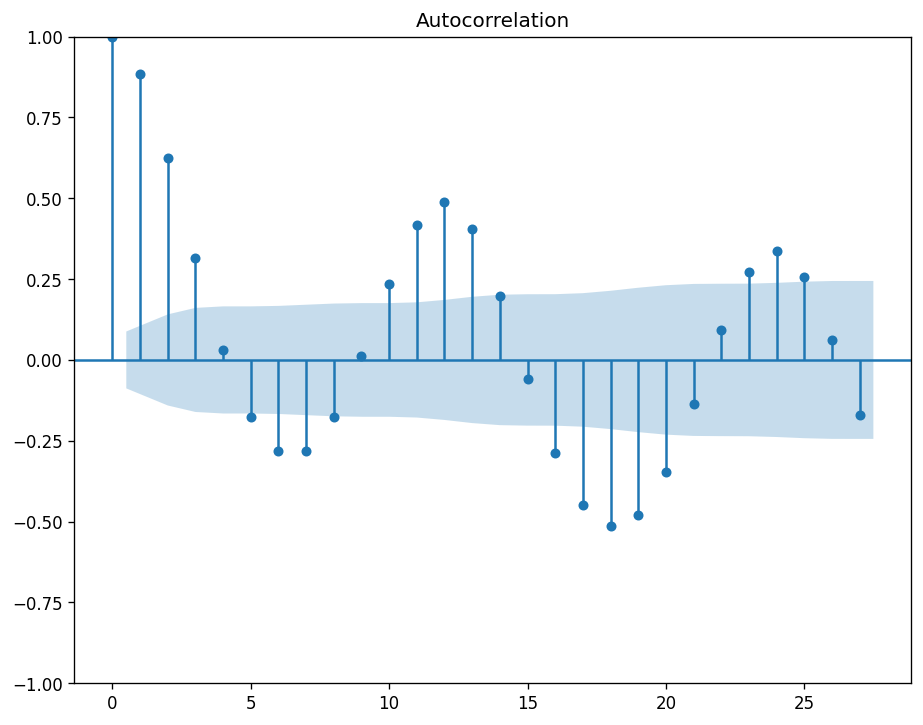

In [152]:
plot_acf(sstoi_df['nino3'].dropna())
plt.show()

Vemos que hay 15 lags extremadamente alejados del threshold, asi que determinamos que q = 15

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  nino3   No. Observations:                  476
Model:                ARIMA(2, 0, 14)   Log Likelihood                -141.007
Date:                Wed, 07 Jun 2023   AIC                            318.015
Time:                        17:04:32   BIC                            392.992
Sample:                    01-01-1982   HQIC                           347.497
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.0616      0.124    210.628      0.000      25.819      26.304
ar.L1          1.7304      0.002    694.715      0.000       1.725       1.735
ar.L2         -0.9974      0.002   -416.102      0.0

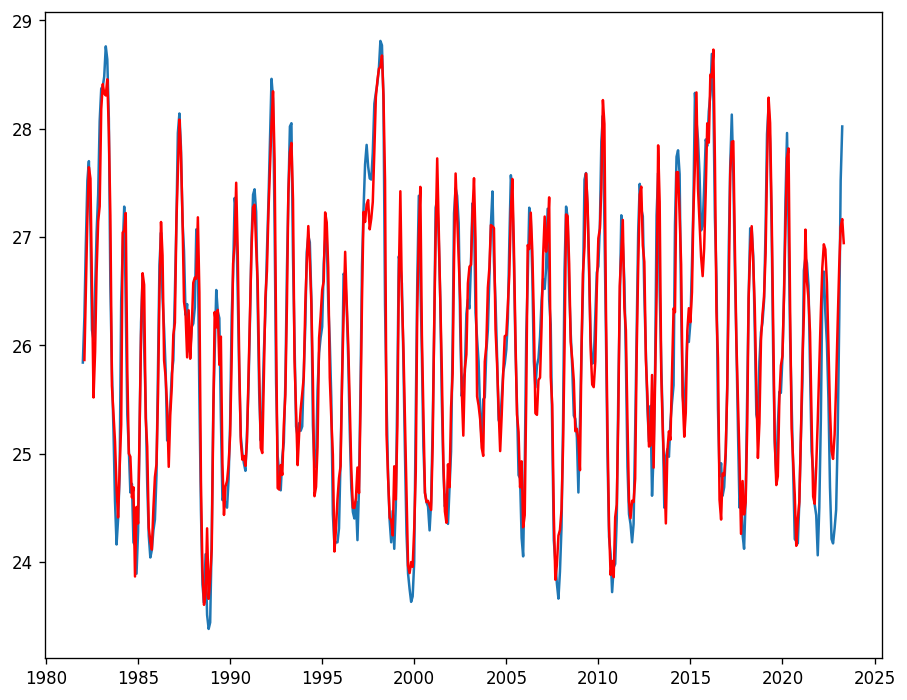

In [153]:
model_3 = ARIMA(sstoi_df['nino3'][:476], order=(2,0,14), missing = 'drop')
results_3 = model_3.fit()
print(results_3.summary())

plt.plot(sstoi_df['nino3'])
plt.plot(results_3.predict(1,496), color='red')

In [154]:
y_pred = pd.Series(results_3.predict(472,496))
y_true = sstoi_df['nino3'][472:]

n=np.array(sstoi_df['nino3'][:472]).shape[0]
d=np.abs(np.diff(np.array(sstoi_df['nino3'][:472]))).sum()/(n-1)

errors = np.abs(y_true - y_pred)

MAPE = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
MASE = errors.mean()/d

print('El mean absolute scaled error (MASE) es: ', MASE, ' y el Mean absolute percentage error (MAPE) es :', MAPE)

El mean absolute scaled error (MASE) es:  1.270298369745284  y el Mean absolute percentage error (MAPE) es : 0.023954900006230535


## Nino 4

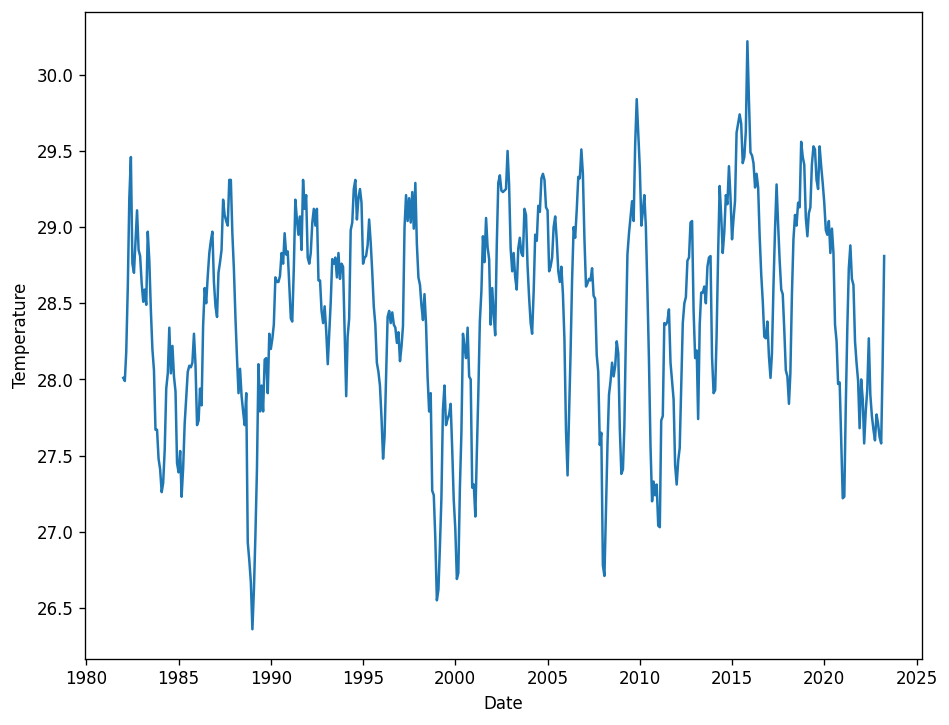

In [155]:
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(sstoi_df['nino4'])

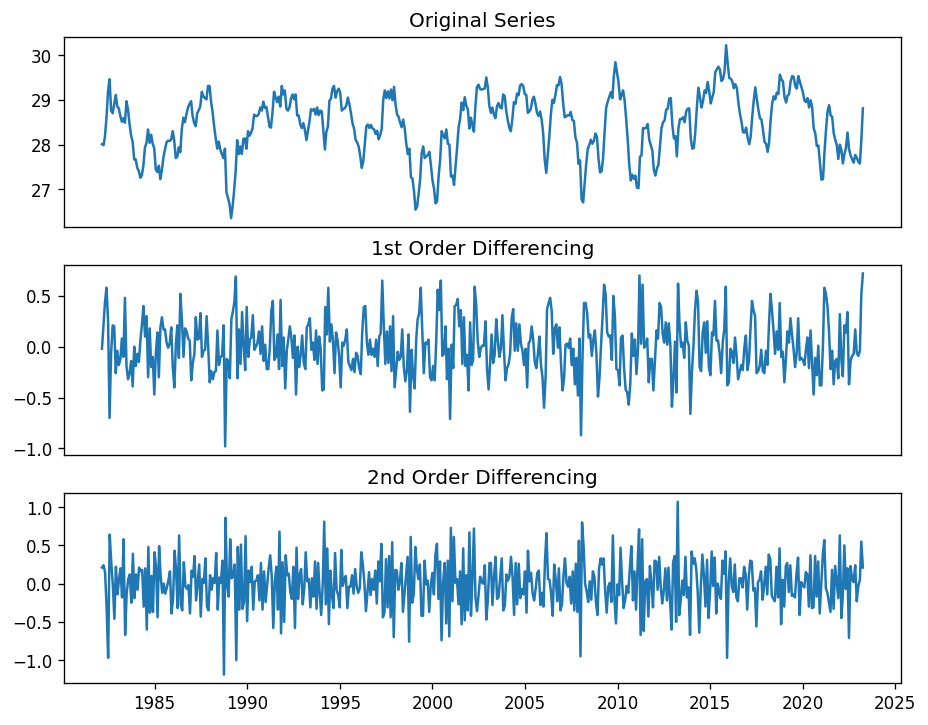

p-value:  0.0006013186043585424
p-value:  1.2366833603520434e-10
p-value:  2.733389822993041e-13


In [156]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(sstoi_df['nino4']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(sstoi_df['nino4'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(sstoi_df['nino4'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

resultd0_4 = adfuller(sstoi_df['nino4'].dropna())
print('p-value: ', resultd0_4[1])

resultd1_4 = adfuller(sstoi_df['nino4'].diff().dropna())
print('p-value: ', resultd1_4[1])

resultd2_4 = adfuller(sstoi_df['nino4'].diff().diff().dropna())
print('p-value: ', resultd2_4[1])

Determinamos que d = 0, debido a que no necesitamos diferenciar para que los datos sean estacionarios

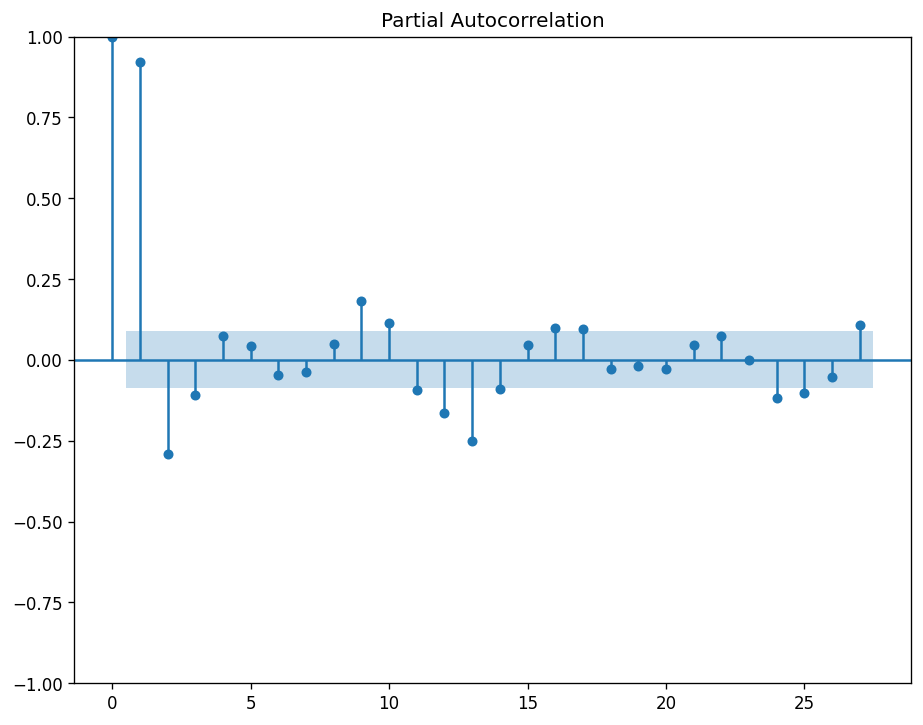

In [157]:
plot_pacf(sstoi_df['nino4'].dropna(), method = 'ywm')
plt.show()

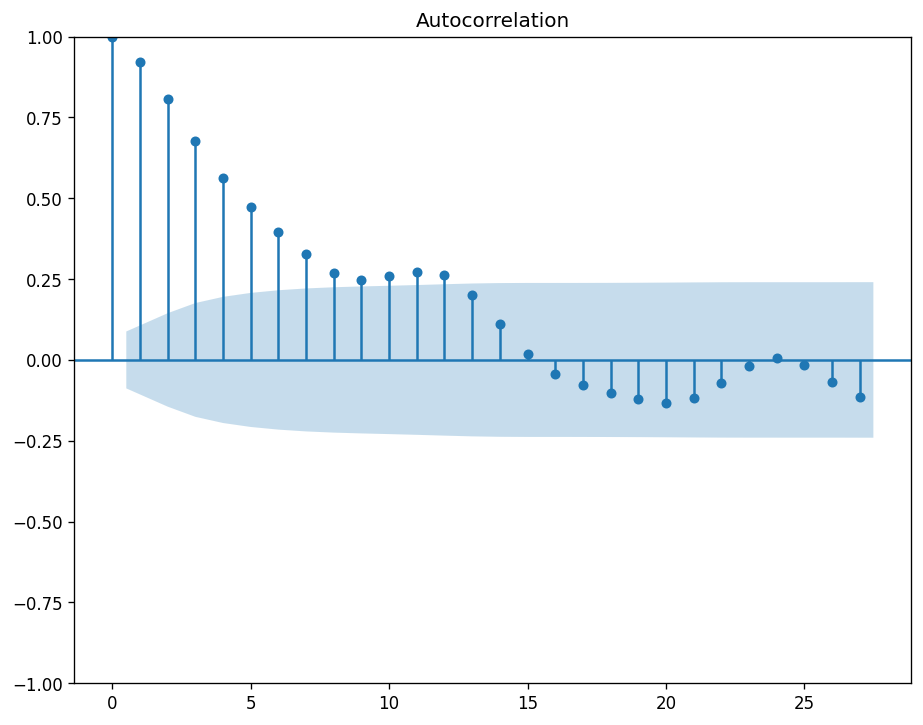

In [158]:
plot_acf(sstoi_df['nino4'].dropna())
plt.show()

Vemos que hay 8 lags extremadamente alejados del threshold, asi que determinamos que q = 8

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  nino4   No. Observations:                  472
Model:                 ARIMA(2, 0, 8)   Log Likelihood                  15.206
Date:                Wed, 07 Jun 2023   AIC                             -6.412
Time:                        17:04:37   BIC                             43.471
Sample:                    01-01-1982   HQIC                            13.210
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4734      0.077    368.841      0.000      28.322      28.625
ar.L1          0.9861      0.054     18.416      0.000       0.881       1.091
ar.L2         -0.8178      0.046    -17.753      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



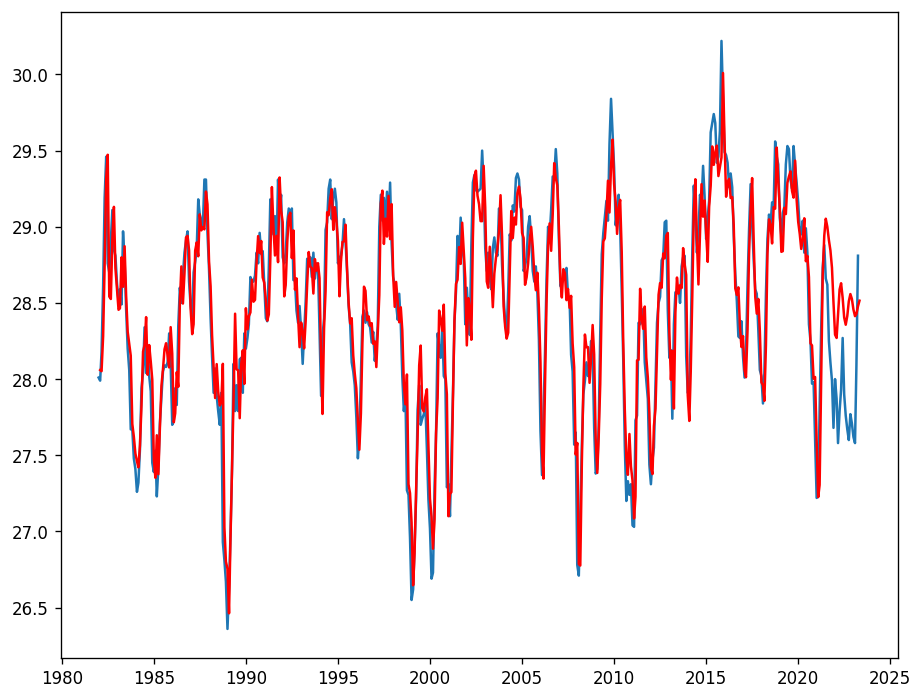

In [159]:
model_4 = ARIMA(sstoi_df['nino4'][:472], order=(2,0,8), missing = 'drop')
results_4 = model_4.fit()
print(results_4.summary())

plt.plot(sstoi_df['nino4'])
plt.plot(results_4.predict(1,496), color='red')

In [160]:
y_pred = pd.Series(results_4.predict(472,496))
y_true = sstoi_df['nino4'][472:]

n=np.array(sstoi_df['nino4'][:472]).shape[0]
d=np.abs(np.diff(np.array(sstoi_df['nino4'][:472]))).sum()/(n-1)

errors = np.abs(y_true - y_pred)

MAPE = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
MASE = errors.mean()/d

print('El mean absolute scaled error (MASE) es: ', MASE, ' y el Mean absolute percentage error (MAPE) es :', MAPE)

El mean absolute scaled error (MASE) es:  2.753691216349155  y el Mean absolute percentage error (MAPE) es : 0.020683413497043383


## Nino 3.4

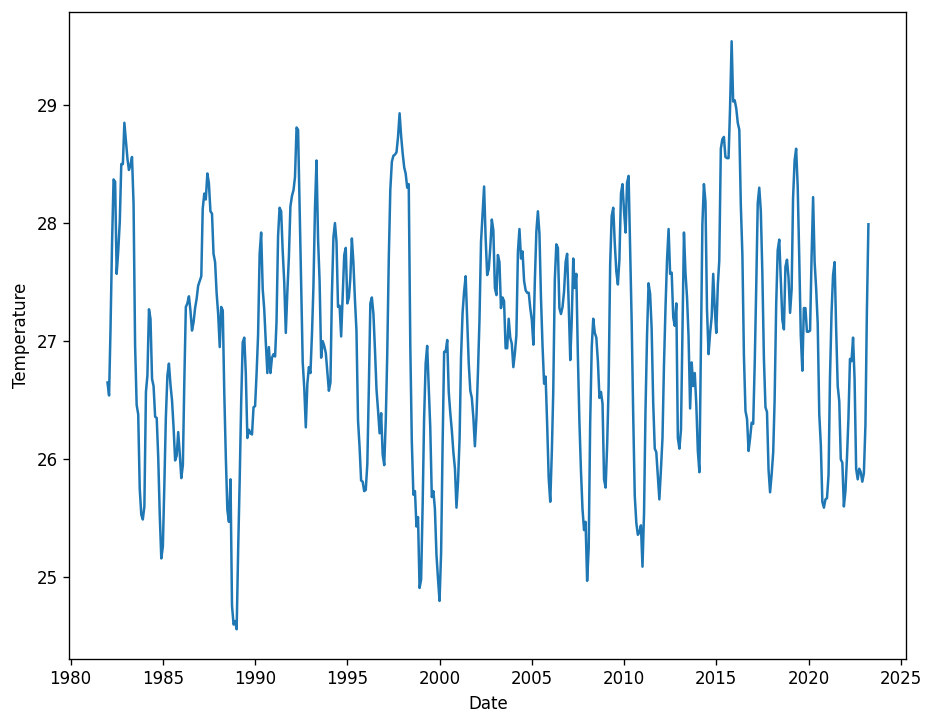

In [161]:
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(sstoi_df['nino3_4'])

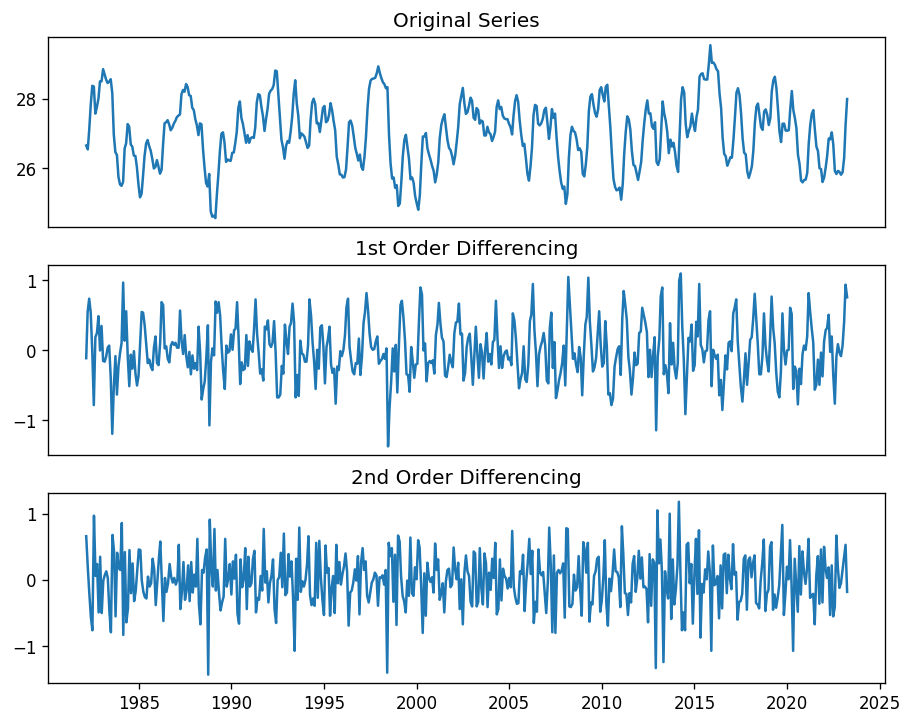

p-value:  9.045256076103628e-06
p-value:  2.2491325486504555e-11
p-value:  4.5366071596642236e-14


In [162]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(sstoi_df['nino3_4']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(sstoi_df['nino3_4'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(sstoi_df['nino3_4'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

resultd0_34 = adfuller(sstoi_df['nino3_4'].dropna())
print('p-value: ', resultd0_34[1])

resultd1_34 = adfuller(sstoi_df['nino3_4'].diff().dropna())
print('p-value: ', resultd1_34[1])

resultd2_34 = adfuller(sstoi_df['nino3_4'].diff().diff().dropna())
print('p-value: ', resultd2_34[1])

Determinamos que d = 0, debido a que no necesitamos diferenciar para que los datos sean estacionarios

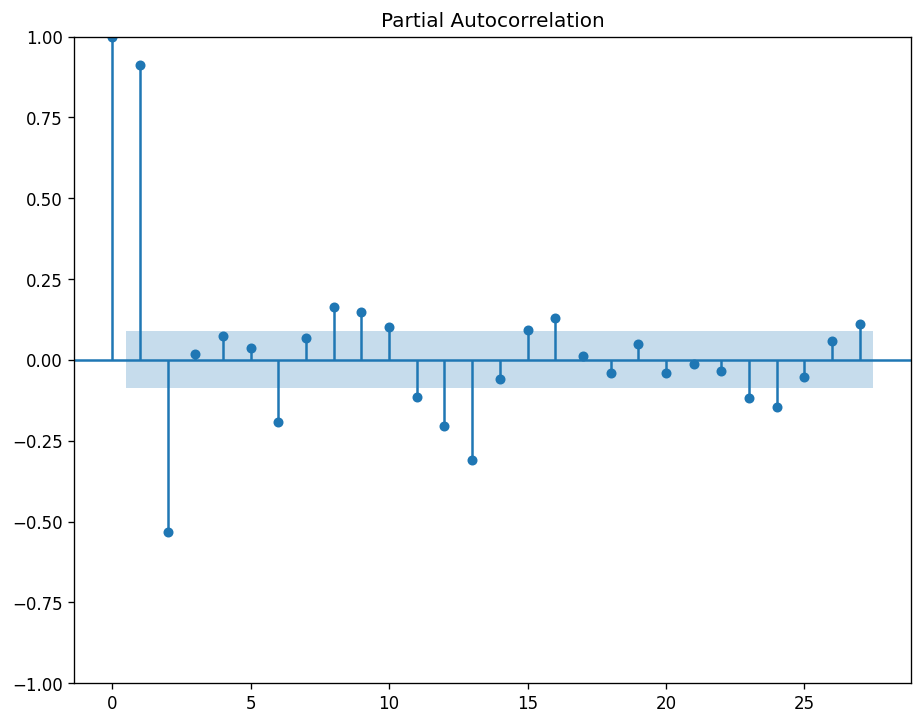

In [163]:
plot_pacf(sstoi_df['nino3_4'].dropna(), method = 'ywm')
plt.show()

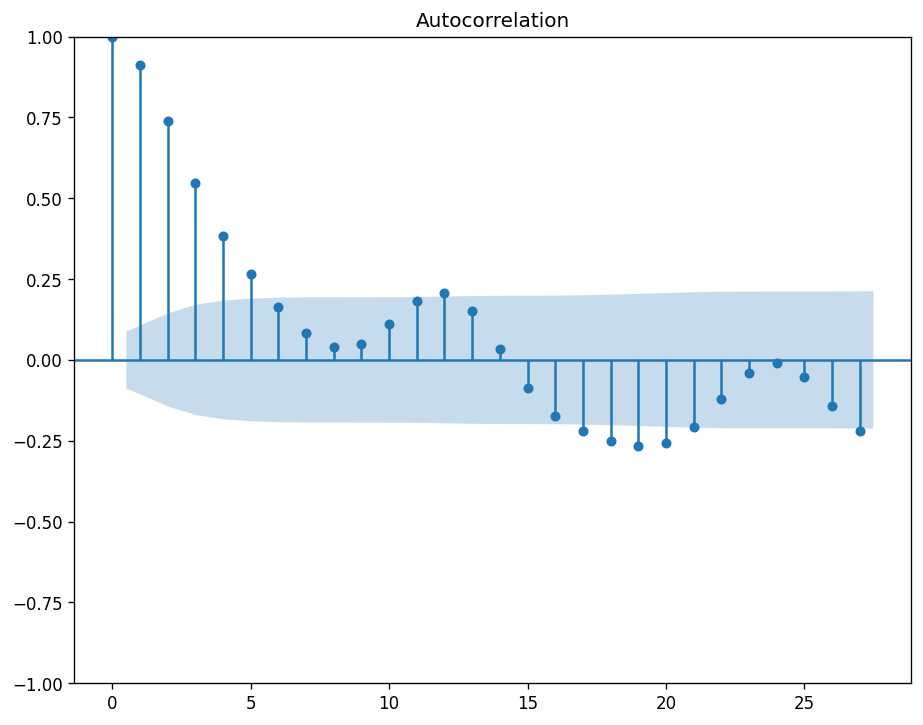

In [164]:
plot_acf(sstoi_df['nino3_4'].dropna())
plt.show()

Vemos que hay 6 lags fuera del threshold, asi que determinamos que q = 6 

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                nino3_4   No. Observations:                  472
Model:                 ARIMA(2, 0, 6)   Log Likelihood                -104.998
Date:                Wed, 07 Jun 2023   AIC                            229.997
Time:                        17:04:43   BIC                            271.566
Sample:                    01-01-1982   HQIC                           246.348
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0405      0.109    248.866      0.000      26.828      27.253
ar.L1          1.4015      0.062     22.555      0.000       1.280       1.523
ar.L2         -0.7024      0.053    -13.137      0.0

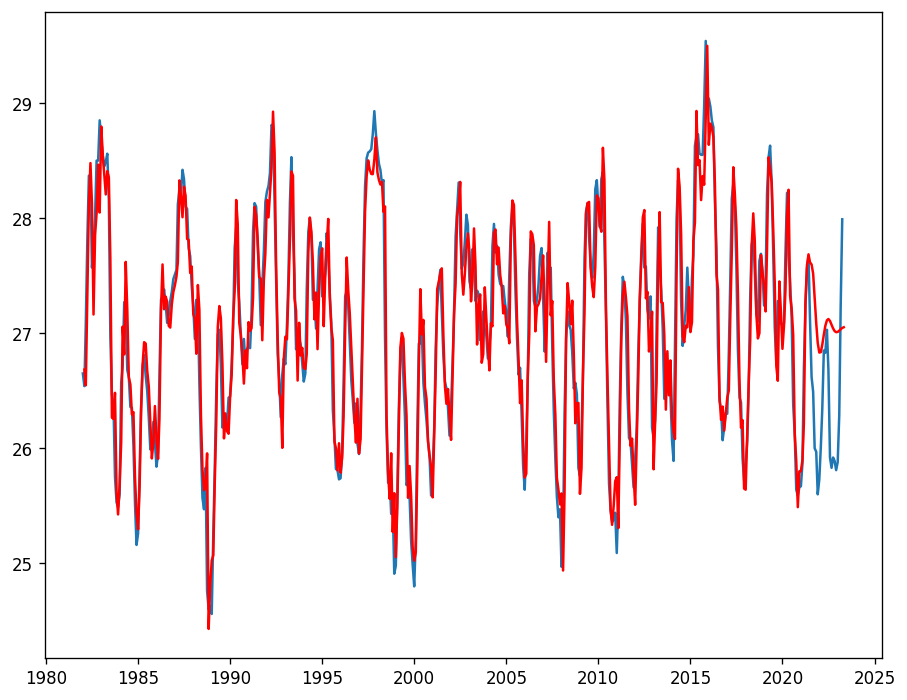

In [165]:
model_34 = ARIMA(sstoi_df['nino3_4'][:472], order=(2,0,6), missing = 'drop')
results_34 = model_34.fit()
print(results_34.summary())

plt.plot(sstoi_df['nino3_4'])
plt.plot(results_34.predict(1,496), color='red')

In [166]:
y_pred = pd.Series(results_34.predict(472,496))
y_true = sstoi_df['nino3_4'][472:]

n=np.array(sstoi_df['nino3_4'][:472]).shape[0]
d=np.abs(np.diff(np.array(sstoi_df['nino3_4'][:472]))).sum()/(n-1)

errors = np.abs(y_true - y_pred)

MAPE = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
MASE = errors.mean()/d

print('El mean absolute scaled error (MASE) es: ', MASE, ' y el Mean absolute percentage error (MAPE) es :', MAPE)

El mean absolute scaled error (MASE) es:  2.5122759830120014  y el Mean absolute percentage error (MAPE) es : 0.029560017666428157


# Forecasting Topológico
https://giotto-ai.github.io/gtda-docs/latest/notebooks/time_series_forecasting.html#univariate-time-series-takensembedding-and-singletakensembedding


In [167]:
n_timestamps = 10

In [168]:
from gtda.time_series import SlidingWindow
from gtda.time_series import PearsonDissimilarity
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude

from sklearn import set_config

from gtda.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from gtda.time_series import TakensEmbedding

In [169]:
X = sstoi_df['nino3_4']
y= sstoi_df['anom3_4']

X

date
1982-01-01    26.65
1982-02-01    26.54
1982-03-01    27.09
1982-04-01    27.83
1982-05-01    28.37
              ...  
2022-12-01    25.81
2023-01-01    25.88
2023-02-01    26.29
2023-03-01    27.23
2023-04-01    27.99
Name: nino3_4, Length: 496, dtype: float64

In [170]:

window_size = 5
stride = 2

SW = SlidingWindow(size=window_size, stride=stride)
X_sw, yr = SW.fit_transform_resample(X, y)
X_sw, yr

(array([[26.54, 27.09, 27.83, 28.37, 28.35],
        [27.83, 28.37, 28.35, 27.57, 27.76],
        [28.35, 27.57, 27.76, 28.01, 28.5 ],
        ...,
        [25.92, 25.83, 25.92, 25.89, 25.81],
        [25.92, 25.89, 25.81, 25.88, 26.29],
        [25.81, 25.88, 26.29, 27.23, 27.99]]),
 array([ 0.65,  0.86,  1.73,  2.21,  1.81,  0.68,  0.45, -0.44, -1.02,
        -1.16, -0.16, -0.54, -1.03, -0.54, -0.75, -1.48, -0.92, -1.1 ,
        -1.08, -0.63, -0.74, -0.59, -0.78, -0.52, -0.33,  0.19,  0.51,
         0.82,  0.82,  0.45,  0.72,  1.2 ,  0.97,  0.77,  0.22, -0.55,
        -1.7 , -1.43, -2.01, -2.01, -1.48, -1.32, -0.67, -0.72, -0.55,
        -0.2 ,  0.01, -0.06, -0.26,  0.09,  0.18,  0.22,  0.14,  0.08,
         0.39,  0.6 ,  0.64,  1.5 ,  1.55,  1.  ,  0.42, -0.08, -0.5 ,
         0.14,  0.34,  0.32,  0.15, -0.04,  0.19,  0.1 , -0.08,  0.08,
         0.13,  0.4 ,  0.6 ,  1.15,  0.64,  0.07, -0.36, -0.57, -0.94,
        -0.91, -0.77, -0.49, -0.48, -0.31, -0.55, -0.6 , -0.39, -0.11,
     

In [172]:
time_delay = 3
dimension = 8

TE = TakensEmbedding(time_delay=time_delay, dimension=dimension)
X_te = TE.fit_transform(X_sw)
X_te

ValueError: ignored

In [ ]:
VR = VietorisRipsPersistence()  # No "precomputed" for point clouds
Ampl = Amplitude()
RFR = RandomForestRegressor()

pipe = make_pipeline(SW, TE, VR, Ampl, RFR)
pipe

In [ ]:
pipe.fit(X, y)
y_pred = pipe.predict(X)
score = pipe.score(X, y)
y_pred, score

## Endogenous target preparation

In [173]:
from gtda.time_series import Labeller

#X = np.arange(10)

X = sstoi_df['nino1+2']

Lab = Labeller(size=1, func=np.max)
Xl, yl = Lab.fit_transform_resample(X, X)
Xl, yl

(array([24.28, 25.38, 25.22, 24.57, 24.  , 22.88, 22.07, 21.71, 21.91,
        22.67, 24.4 , 25.73, 26.82, 27.65, 28.34, 28.1 , 27.87, 27.2 ,
        25.69, 23.73, 22.16, 21.98, 22.01, 22.95, 24.35, 25.23, 25.72,
        25.28, 23.44, 22.21, 21.15, 20.28, 20.2 , 20.45, 21.42, 22.62,
        23.59, 24.79, 25.66, 24.3 , 22.72, 21.83, 20.46, 19.6 , 19.23,
        19.76, 20.83, 22.34, 24.5 , 25.88, 25.91, 24.82, 23.34, 22.16,
        21.22, 20.72, 20.47, 21.  , 21.62, 22.96, 25.06, 26.75, 27.54,
        26.6 , 25.45, 23.83, 22.53, 21.58, 21.29, 22.17, 22.55, 23.28,
        24.33, 25.68, 25.75, 24.66, 23.48, 21.58, 20.23, 19.19, 19.06,
        19.35, 20.41, 21.67, 24.04, 25.86, 26.6 , 25.6 , 23.36, 22.03,
        21.14, 20.35, 19.7 , 20.2 , 21.19, 22.26, 23.92, 25.66, 26.1 ,
        25.03, 24.  , 22.77, 20.93, 20.39, 19.98, 20.08, 20.73, 22.12,
        23.73, 25.7 , 26.32, 25.21, 24.65, 23.07, 22.06, 20.98, 20.72,
        21.09, 21.92, 23.13, 24.59, 26.25, 27.38, 27.17, 26.09, 23.66,
      

In [174]:
print(len(X))
print(len(Xl))
print(len(yl))
print(len(y_pred))

496
495
495
25


In [175]:
train_x = X[:448]
train_y = X[448:496]


In [176]:
print(len(X))
print(len(Xl))
print(len(yl))
print(len(y_pred))

print(len(train_x))
print(len(train_y))

496
495
495
25
448
48


In [177]:
SW = SlidingWindow(size=24)
TE = TakensEmbedding(time_delay=3, dimension=8)
VR = VietorisRipsPersistence()
Ampl = Amplitude()
RFR = RandomForestRegressor(n_estimators=10000)

# Full pipeline including the regressor
pipe = make_pipeline(Lab, SW, TE, VR, Ampl, RFR)
pipe

Pipeline(steps=[('labeller',
                 Labeller(func=<function amax at 0x7f27dab14550>, size=1)),
                ('slidingwindow', SlidingWindow(size=24)),
                ('takensembedding', TakensEmbedding(dimension=8, time_delay=3)),
                ('vietorisripspersistence', VietorisRipsPersistence()),
                ('amplitude', Amplitude()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10000))])

In [178]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [179]:
pipe.fit(train_x, train_x)
y_pred = pipe.predict(train_y)
y_pred

array([22.04297919, 22.04297919, 20.14578182, 21.47363826, 22.8973989 ,
       22.8973989 , 20.46413223, 24.28136088, 24.28136088, 24.51845164,
       24.51845164, 20.19000633, 20.56256736, 20.56256736, 21.028007  ,
       21.75704093, 21.75704093, 24.925195  , 21.75715552, 21.75715552,
       24.0514212 , 22.04936972, 22.04936972, 24.70760222])

In [180]:
len(y_pred)

24

In [181]:
#dates_y=sstoi_df.index[473:496]
dates_y=sstoi_df.index.values[472:496]
type(dates_y)


numpy.ndarray

In [182]:
y_og = X[472:496]

In [183]:
print(len(train_y))

print(len(y_pred))
print(len(y_og))
print(len(dates_y))

48
24
24
24


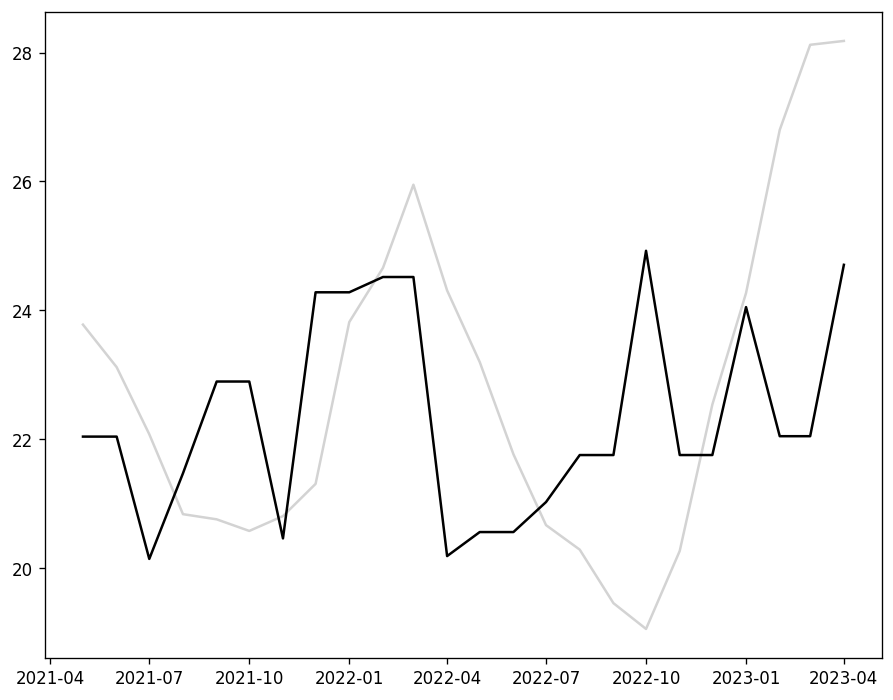

In [184]:
plt.plot(dates_y,y_og,color='lightgray')
plt.plot(dates_y,y_pred,color='black')
plt.show()

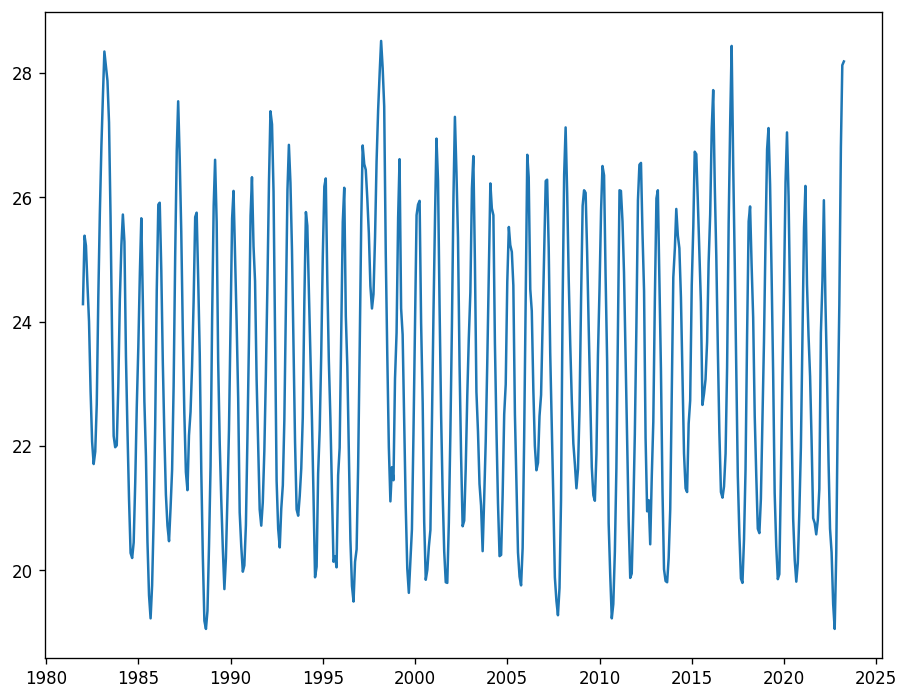

In [185]:
plt.plot(X)

In [186]:
pipe.fit(X, X)
y_pred = pipe.predict(X)
y_pred

array([24.23690498, 25.979002  , 25.04653654, 25.04653654, 24.259227  ,
       21.75579137, 21.75579137, 21.114562  , 20.8913775 , 20.8913775 ,
       21.586125  , 22.94079331, 22.94079331, 25.615821  , 24.85863822,
       24.85863822, 22.293589  , 21.51251875, 21.51251875, 20.158279  ,
       20.27533608, 20.27533608, 20.822434  , 23.77267677, 23.77267677,
       25.00969913, 25.26348189, 25.26348189, 22.90158178, 22.90158178,
       21.56358333, 20.50179179, 20.50179179, 22.24187127, 22.61219672,
       22.61219672, 24.66570347, 26.19789277, 26.19789277, 24.96935091,
       24.75090188, 24.75090188, 22.86072361, 21.6033745 , 21.6033745 ,
       22.45284422, 23.22160552, 23.22160552, 23.76982843, 24.16919513,
       24.16919513, 23.1777526 , 24.16919513, 24.16919513, 21.26328019,
       19.76158256, 19.76158256, 20.8343956 , 21.59935606, 21.59935606,
       24.05590563, 25.87844873, 25.87844873, 24.06557648, 24.07129248,
       22.10443596, 22.10443596, 20.49796893, 20.50361357, 20.50

In [187]:
y_pred

array([24.23690498, 25.979002  , 25.04653654, 25.04653654, 24.259227  ,
       21.75579137, 21.75579137, 21.114562  , 20.8913775 , 20.8913775 ,
       21.586125  , 22.94079331, 22.94079331, 25.615821  , 24.85863822,
       24.85863822, 22.293589  , 21.51251875, 21.51251875, 20.158279  ,
       20.27533608, 20.27533608, 20.822434  , 23.77267677, 23.77267677,
       25.00969913, 25.26348189, 25.26348189, 22.90158178, 22.90158178,
       21.56358333, 20.50179179, 20.50179179, 22.24187127, 22.61219672,
       22.61219672, 24.66570347, 26.19789277, 26.19789277, 24.96935091,
       24.75090188, 24.75090188, 22.86072361, 21.6033745 , 21.6033745 ,
       22.45284422, 23.22160552, 23.22160552, 23.76982843, 24.16919513,
       24.16919513, 23.1777526 , 24.16919513, 24.16919513, 21.26328019,
       19.76158256, 19.76158256, 20.8343956 , 21.59935606, 21.59935606,
       24.05590563, 25.87844873, 25.87844873, 24.06557648, 24.07129248,
       22.10443596, 22.10443596, 20.49796893, 20.50361357, 20.50

In [188]:
len(y_pred)

472

In [189]:
y_og2= X[5:496]
len(y_og2)

491

In [190]:
#dates_y=sstoi_df.index[473:496]
dates_y2=sstoi_df.index.values[5:496]
type(dates_y2)

numpy.ndarray

ValueError: ignored

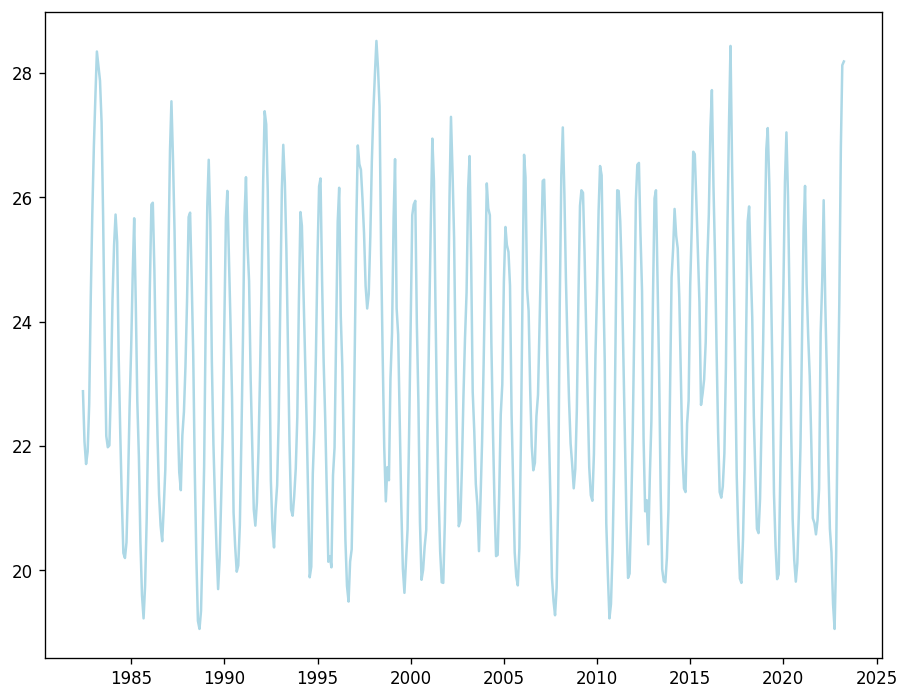

In [191]:
plt.plot(dates_y2 ,y_og2, color='lightblue')
plt.plot(dates_y2,y_pred, color='black')

# Mapper - Ignorar el titulo del grafo, hacer caso al nombre del archivo en GitHub

La proyeccion se hizo sobre las anomalías y se uso como función para colorear los nodos del grafo, se hicieron reducciones de dimensionalidad con 2 componentes y los algoritmos de clustering se hicieron con 3 clusters, esto se hace para poder encontrar un grafo en donde estén bien diferenciados los fenómenos del niño, la niña y el estado normal.

In [ ]:
#Librerías basicas de manipulación de objetos 
import pandas as pd
import seaborn as sns
import numpy as np

#Métodos estadisticos
from scipy.stats import anderson
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## Archivo .txt

Lectura y estructuración de los datos en un DataFrame

In [ ]:
#Se leen los datos del archivo .txt
data_reto2 = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\sstoi.indices.txt')

In [ ]:
data_reto2.columns=['x'] # renombrar la columna de los datos
df3 = data_reto2['x'].str.split(n=9, expand=True) # Se divide en las columnas de datos originales
df3.columns = ['column{}'.format(x+1) for x in df3.columns]
df3.rename(columns={'column1': 'Year','column2':'Month',
                    'column3': 'nino1+2','column4':'anom1+2',
                    'column5': 'nino3','column6':'anom3',
                    'column7': 'nino4','column8':'anom4',
                    'column9': 'nino3_4','column10':'anom3_4'},inplace=True) #Se cambia el nombre de las columnas
df3['date'] = pd.to_datetime(dict(year=df3.Year, month=df3.Month, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

In [ ]:
#Se leen los datos del archivo .txt
soi = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\soi.txt')

In [ ]:
soi.columns=['x'] # renombrar la columna de los datos
soi3 = soi['x'].str.split(n=12, expand=True) # Se divide en las columnas de datos originales
soi3.columns = ['column{}'.format(x+1) for x in soi3.columns]
soi3.rename(columns={'column1': 'Year','column2': '1',
                    'column3': '2','column4': '3',
                    'column5': '4','column6': '5',
                    'column7': '6','column8':'7',
                    'column9': '8','column10': '9',
                    'column11': '10', 'column12': '11', 
                    'column13': '12'},inplace=True) #Se cambia el nombre de las columnas
#soi3['date'] = pd.to_datetime(dict(year=soi3.Year, month=1, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

# Create a new column for the year
soi3['Year'] = soi3['Year'].astype(str)

# Reshape the dataframe to have a single column for months
soi3 = soi3.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Create a datetime column using the Year and Month columns
soi3['Date'] = pd.to_datetime(soi3['Year'] + '-' + soi3['Month'], format="%Y/%m/%d", dayfirst=True)    

# Drop the original Month column
soi3 = soi3.drop('Month', axis=1)

soi3 = soi3.sort_values('Date')

# Replace -999.9 with NaN to represent missing values
soi3.replace('-999.9', float('nan'), inplace=True)
soi3.dropna(inplace=True)

In [ ]:
meiv2 = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\nino_miv2.txt', delim_whitespace=True)

#remove the last row
meiv3 = meiv2[:-1]

# Create a new column for the year
meiv3['Year'] = meiv3['Year'].astype(str)

# Reshape the dataframe to have a single column for months
meiv3 = meiv3.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Create a datetime column using the Year and Month columns
meiv3['Date'] = pd.to_datetime(meiv3['Year'] + '-' + meiv3['Month'], format="%Y/%m/%d", dayfirst=True)    

# Drop the original Month column
meiv3 = meiv3.drop('Month', axis=1)

meiv3 = meiv3.sort_values('Date')

In [ ]:
#Se leen los datos del archivo .txt
oni = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\oni.txt')

In [ ]:
oni.columns=['x'] # renombrar la columna de los datos
oni3 = oni['x'].str.split(n=12, expand=True) # Se divide en las columnas de datos originales
oni3.columns = ['column{}'.format(x+1) for x in oni3.columns]
oni3.rename(columns={'column1': 'SEAS','column2':'Year',
                    'column3': 'TOTAL','column4':'ANOM'},inplace=True) #Se cambia el nombre de las columnas
oni3['date'] = pd.to_datetime(dict(year=oni3.Year, month=1, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

In [ ]:
#Se leen los datos del archivo .txt
olr = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\olr.txt')

In [ ]:
olr.columns=['x'] # renombrar la columna de los datos
olr3 = olr['x'].str.split(n=12, expand=True) # Se divide en las columnas de datos originales
olr3.columns = ['column{}'.format(x+1) for x in olr3.columns]
olr3.rename(columns={'column1': 'Year','column2': '1',
                    'column3': '2','column4': '3',
                    'column5': '4','column6': '5',
                    'column7': '6','column8':'7',
                    'column9': '8','column10': '9',
                    'column11': '10', 'column12': '11', 
                    'column13': '12'},inplace=True) #Se cambia el nombre de las columnas
#olr3['date'] = pd.to_datetime(dict(year=olr3.Year, month=1, day=1)) #Se genera la columna fecha a partir de las columnas mes y año


# Create a new column for the year
olr3['Year'] = olr3['Year'].astype(str)

# Reshape the dataframe to have a single column for months
olr3 = olr3.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Create a datetime column using the Year and Month columns
olr3['Date'] = pd.to_datetime(olr3['Year'] + '-' + olr3['Month'], format="%Y/%m/%d", dayfirst=True)    

# Drop the original Month column
olr3 = olr3.drop('Month', axis=1)

olr3 = olr3.sort_values('Date')

In [ ]:
olr.columns=['x'] # renombrar la columna de los datos
olr4 = olr['x'].str.split(n=12, expand=True) # Se divide en las columnas de datos originales
olr4.columns = ['column{}'.format(x+1) for x in olr4.columns]
olr4.rename(columns={'column1': 'Year','column2': '1',
                    'column3': '2','column4': '3',
                    'column5': '4','column6': '5',
                    'column7': '6','column8':'7',
                    'column9': '8','column10': '9',
                    'column11': '10', 'column12': '11', 
                    'column13': '12'},inplace=True) #Se cambia el nombre de las columnas
#olr4['date'] = pd.to_datetime(dict(year=olr4.Year, month=1, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

olr5 = olr4.drop(['Year'], axis=1)

# Replace -999.9 with NaN to represent missing values
olr5.replace('-999.9', float('nan'), inplace=True)

# Transpose the DataFrame
olr5 = olr5.T

# Perform LOCF imputation
olr5.fillna(method='ffill', inplace=True)

# Transpose the DataFrame back to the original shape
olr5 = olr5.T

# Print the imputed DataFrame
olr5['Year'] = olr4['Year']

# Create a new column for the year
olr5['Year'] = olr5['Year'].astype(str)

# Reshape the dataframe to have a single column for months
olr5 = olr5.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Create a datetime column using the Year and Month columns
olr5['Date'] = pd.to_datetime(olr5['Year'] + '-' + olr5['Month'], format="%Y/%m/%d", dayfirst=True)    

# Drop the original Month column
olr5 = olr5.drop('Month', axis=1)

olr5 = olr5.sort_values('Date')

#remove first 5 rows and last 8

olr5 = olr5[5:-8]

In [ ]:
#Se leen los datos del archivo .txt
data_reto2 = pd.read_csv('C:\\Users\\Alfre\\Escritorio\\vs_code\\Topología\\sstoi.indices.txt')

In [ ]:
data_reto2.columns=['x'] # renombrar la columna de los datos
df3 = data_reto2['x'].str.split(n=9, expand=True) # Se divide en las columnas de datos originales
df3.columns = ['column{}'.format(x+1) for x in df3.columns]
df3.rename(columns={'column1': 'Year','column2':'Month',
                    'column3': 'nino1+2','column4':'anom1+2',
                    'column5': 'nino3','column6':'anom3',
                    'column7': 'nino4','column8':'anom4',
                    'column9': 'nino3_4','column10':'anom3_4'},inplace=True) #Se cambia el nombre de las columnas
df3['date'] = pd.to_datetime(dict(year=df3.Year, month=df3.Month, day=1)) #Se genera la columna fecha a partir de las columnas mes y año

In [ ]:
#Se crea un nuevo dataframe sin las columnas Year y Month y con la fecha como index
sstoi_df= df3[['nino1+2',	'anom1+2',	'nino3',	'anom3',	'nino4',	'anom4',	'nino3_4',	'anom3_4',	'date']]
sstoi_df = sstoi_df.set_index(['date'])
sstoi_df = sstoi_df.apply(pd.to_numeric) # Convwertir los datos de object a numeric
sstoi_df

#### Ahora vamos a usar mapper en combinación con los 3 nuevos indices en combinacion con cada uno de los ninos

In [ ]:
soi3.head()

In [ ]:
olr5.head()

In [ ]:
sstoi_df.head()

In [ ]:
meiv3.head()

In [ ]:
#merge meiv3, soi3, olr5 on Date

merge = pd.merge(meiv3, soi3, on='Date', how='inner') #Se unen los dataframes

merge1 = pd.merge(merge, olr5, on='Date', how='inner') #Se unen los dataframes

merge1.rename(columns={'Value_x': 'MEIV','Value_y':'SOI', 'Value':'OLR'},inplace=True) #Se cambia el nombre de las columnas

merge1 = merge1[['Date', 'MEIV', 'SOI', 'OLR']] #Se seleccionan las columnas de interés

In [ ]:
merge1

In [ ]:
soi_merge = sstoi_df.reset_index() #Se resetea el index para poder unirlo con el dataframe merge1

soi_merge.rename(columns={'date': 'Date'},inplace=True) #Se cambia el nombre de las columnas

merge2 = pd.merge(merge1, soi_merge, on='Date', how='inner') #Se unen los dataframes

In [ ]:
merge2

### comenzamos a probar mapper con diferentes parametros para ver que podemos obtener

In [ ]:
import kmapper as km
from kmapper.jupyter import display
import sklearn

In [ ]:
import kmapper as km
from kmapper import Cover, jupyter
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#take the column date and create a new column with month
merge2['Month'] = merge2['Date'].dt.month

In [ ]:
#Apply MinMacScaler to the data

scaler = MinMaxScaler()
merge2[['Month', 'MEIV', 'SOI', 'OLR', 'nino1+2', 'anom1+2', 'nino3', 'anom3', 'nino4', 'anom4', 'nino3_4', 'anom3_4']] = scaler.fit_transform(merge2[['Month', 'MEIV', 'SOI',
'OLR', 'nino1+2', 'anom1+2', 'nino3', 'anom3', 'nino4', 'anom4', 'nino3_4', 'anom3_4']]) #Se escalan los datos

In [ ]:
merge2

#### primero usaremos nino1+2

In [ ]:
merge3 = merge2[['MEIV', 'SOI', 'OLR', 'nino3_4', 'anom3_4','Month']] #Se seleccionan las columnas de interés

In [ ]:
data = merge3.to_numpy() #Se convierte el dataframe en un array

#convert all columns to numeric
data = data.astype(float)

In [ ]:
from sklearn import cluster

#### keppler mapper

In [ ]:
mapper = km.KeplerMapper()
projected_data = mapper.fit_transform(data, projection=[4])

covering=km.Cover(n_cubes=5,perc_overlap=0.33)

In [ ]:
G = mapper.map(projected_data, data, sklearn.cluster.KMeans(n_clusters=3),cover=covering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
G = mapper.map(projected_data, data, clusterer=AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine"), cover=covering)

In [ ]:
from sklearn.cluster import DBSCAN
G = mapper.map(projected_data, data, clusterer=DBSCAN(eps=0.5, min_samples=5), cover=covering)

In [ ]:
from sklearn.cluster import SpectralClustering
G = mapper.map(projected_data, data, clusterer=SpectralClustering(n_clusters=3), cover=covering)

In [ ]:
from sklearn.cluster import MeanShift
G = mapper.map(projected_data, data, clusterer=MeanShift(), cover=covering)

In [ ]:
mapper.visualize(G, 
                title='Mapper',
                color_values = merge3['nino3_4'].to_numpy(),
                color_function_name = 'Mean',
                node_color_function=np.array(['average','std','sum','max','min']))

km.jupyter.display("mapper_reto_nino1_2.html")

#### umap

In [ ]:
umap_transformer = umap.UMAP(n_neighbors=3, n_components=2, random_state=42)
projected_data = umap_transformer.fit_transform(data)

covering=km.Cover(n_cubes=3,perc_overlap=0.33)

In [ ]:
G = mapper.map(projected_data, data, sklearn.cluster.KMeans(n_clusters=3),cover=covering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
G = mapper.map(projected_data, data, clusterer=AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine"), cover=covering)

In [ ]:
from sklearn.cluster import DBSCAN
G = mapper.map(projected_data, data, clusterer=DBSCAN(eps=0.5, min_samples=5), cover=covering)

In [ ]:
from sklearn.cluster import SpectralClustering
G = mapper.map(projected_data, data, clusterer=SpectralClustering(n_clusters=3), cover=covering)

In [ ]:
from sklearn.cluster import MeanShift
G = mapper.map(projected_data, data, clusterer=MeanShift(), cover=covering)

In [ ]:
mapper.visualize(G, 
                title='Mapper',
                color_values = merge3['nino3_4'].to_numpy(),
                color_function_name = 'Mean',
                node_color_function=np.array(['average','std','sum','max','min']))

km.jupyter.display("mapper_reto_nino1_2.html")

#### TSNE

In [ ]:
from sklearn.manifold import TSNE
tsne_transformer = TSNE(n_components=2, random_state=42)
projected_data = tsne_transformer.fit_transform(data)

covering=km.Cover(n_cubes=3,perc_overlap=0.33)

In [ ]:
G = mapper.map(projected_data, data, sklearn.cluster.KMeans(n_clusters=3),cover=covering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
G = mapper.map(projected_data, data, clusterer=AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine"), cover=covering)

In [ ]:
from sklearn.cluster import DBSCAN
G = mapper.map(projected_data, data, clusterer=DBSCAN(eps=0.5, min_samples=5), cover=covering)

In [ ]:
from sklearn.cluster import SpectralClustering
G = mapper.map(projected_data, data, clusterer=SpectralClustering(n_clusters=3), cover=covering)

In [ ]:
from sklearn.cluster import MeanShift
G = mapper.map(projected_data, data, clusterer=MeanShift(), cover=covering)

In [ ]:
mapper.visualize(G, 
                title='Mapper',
                color_values = merge3['nino3_4'].to_numpy(),
                color_function_name = 'Mean',
                node_color_function=np.array(['average','std','sum','max','min']))

km.jupyter.display("mapper_reto_nino1_2.html")

#### PCA

In [ ]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=2)
projected_data = pca_transformer.fit_transform(data)

covering=km.Cover(n_cubes=3,perc_overlap=0.33)

In [ ]:
G = mapper.map(projected_data, data, sklearn.cluster.KMeans(n_clusters=3),cover=covering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
G = mapper.map(projected_data, data, clusterer=AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine"), cover=covering)

In [ ]:
from sklearn.cluster import DBSCAN
G = mapper.map(projected_data, data, clusterer=DBSCAN(eps=0.5, min_samples=5), cover=covering)

In [ ]:
from sklearn.cluster import SpectralClustering
G = mapper.map(projected_data, data, clusterer=SpectralClustering(n_clusters=3), cover=covering)

In [ ]:
from sklearn.cluster import MeanShift
G = mapper.map(projected_data, data, clusterer=MeanShift(), cover=covering)

In [ ]:
mapper.visualize(G, 
                title='Mapper',
                color_values = merge3['nino3_4'].to_numpy(),
                color_function_name = 'Mean',
                node_color_function=np.array(['average','std','sum','max','min']))

km.jupyter.display("mapper_reto_nino1_2.html")

#### LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
lle_transformer = LocallyLinearEmbedding(n_components=2)
projected_data = lle_transformer.fit_transform(data)

covering=km.Cover(n_cubes=3,perc_overlap=0.33)

In [ ]:
G = mapper.map(projected_data, data, sklearn.cluster.KMeans(n_clusters=3),cover=covering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
G = mapper.map(projected_data, data, clusterer=AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine"), cover=covering)

In [ ]:
from sklearn.cluster import DBSCAN
G = mapper.map(projected_data, data, clusterer=DBSCAN(eps=0.5, min_samples=5), cover=covering)

In [ ]:
from sklearn.cluster import SpectralClustering
G = mapper.map(projected_data, data, clusterer=SpectralClustering(n_clusters=3), cover=covering)

In [ ]:
from sklearn.cluster import MeanShift
G = mapper.map(projected_data, data, clusterer=MeanShift(), cover=covering)

In [ ]:
mapper.visualize(G, 
                title='Performance Data based on SSL nino1+2 and Mean of other four',
                color_values = merge3['nino3_4'].to_numpy(),
                color_function_name = 'Mean',
                node_color_function=np.array(['average','std','sum','max','min']))

km.jupyter.display("mapper_reto_nino1_2.html")

#SOS

In [ ]:
from functools import partial
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import clone

mean = FunctionTransformer(partial(np.mean, axis=1, keepdims=True))
var = FunctionTransformer(partial(np.var, axis=1, keepdims=True))

pipe_topology = make_pipeline(TE, VR, Ampl)

feature_union = FeatureUnion([("window_mean", mean),
                              ("window_variance", var),
                              ("window_topology", pipe_topology)])

pipe = make_pipeline(SW, feature_union, RFR)
pipe

In [ ]:
pipe.fit(train_x, train_x)
y_pred = pipe.predict(X[448:496])
y_pred

In [ ]:
len(X[448:496])

In [ ]:
len(y_pred[1:])

In [ ]:
plt.plot(dates_y,y_og,color='lightgray')
plt.plot(dates_y,y_pred[1:],color='black')
plt.show()